# Gaussian Processes for Yield Prediction - Wheat

<font size=5>
We try now to rebuild some models on another vegetable

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
import pickle

%reload_ext autoreload
%autoreload 2

from utils import *
from gaussian_processes import GaussianProcess

az.style.use('arviz-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set random seed
np.random.seed(42)

## Load and build the dataset (in the same way)

In [3]:
# Load the dataset
cy = pd.read_csv('data/yield_processed.csv', index_col=0)
cy = cy[cy['Item'] == 'Wheat'].drop(columns='Item').reset_index(drop=True)

# Get geodata for plot world map
countries = cy['Area'].unique()
world = get_geodata(countries)

# Get the features and the target feature
cy = cy.drop('Area', axis=1)
print(cy.describe())
x_data = cy.drop('hg/ha_yield', axis=1).to_numpy()
y_data = cy['hg/ha_yield'].to_numpy()

# Set the indices of the sample for testing
num_test_results = 10
test_indices = np.random.choice(len(y_data), size=num_test_results, replace=False)
test_indices = np.sort(test_indices)
train_indices = np.array([i for i in range(len(y_data)) if i not in test_indices])

# Standardize the data
x_std_data, x_mean, x_stddev = standardize_data(x_data)
y_std_data, y_mean, y_stddev = standardize_data(y_data)

# Get 10 samples to plot
x_test_std_data, y_test_std_data = x_std_data[test_indices], y_std_data[test_indices]

y_data_full = y_data.copy()
x_test_data, y_test_data = x_data[test_indices], y_data[test_indices]

n_samples, n_features = x_std_data.shape
x_std_data.shape, y_std_data.shape, x_test_std_data.shape, y_test_std_data.shape

        hg/ha_yield  avg_rain_mm_per_year  pesticides_kg_per_ha   avg_temp  \
count     82.000000             82.000000             82.000000  82.000000   
mean   30830.865532            904.634146              3.219700  16.389268   
std    20220.774362            617.961574              4.203318   6.927212   
min     5574.130435             51.000000              0.003028   3.459565   
25%    16741.019928            536.250000              0.334567   9.832554   
50%    24589.978261            695.500000              1.631862  16.817174   
75%    41989.315217           1218.000000              3.840845  21.324022   
max    84988.615385           3240.000000             20.888427  29.718696   

             lat         lon         elev  
count  82.000000   82.000000    82.000000  
mean   22.939943   17.304159   687.780488  
std    28.745417   49.114882   617.341393  
min   -41.000000 -102.000000    28.000000  
25%     1.000000    4.437500   314.000000  
50%    29.000000   21.000000   48

((82, 6), (82,), (10, 6), (10,))

## Exponential quadratic kernel

<font size=5>
    
 - Change from Gamma to HalfNormal for Length Scale
 - Double number of samples 
 - Target accept to 0.95
    
(w.r.t potato)

In [12]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    # Instantiate the covariance function
    cov = pm.gp.cov.ExpQuad(n_features, ls) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 1.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [13]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 2563 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


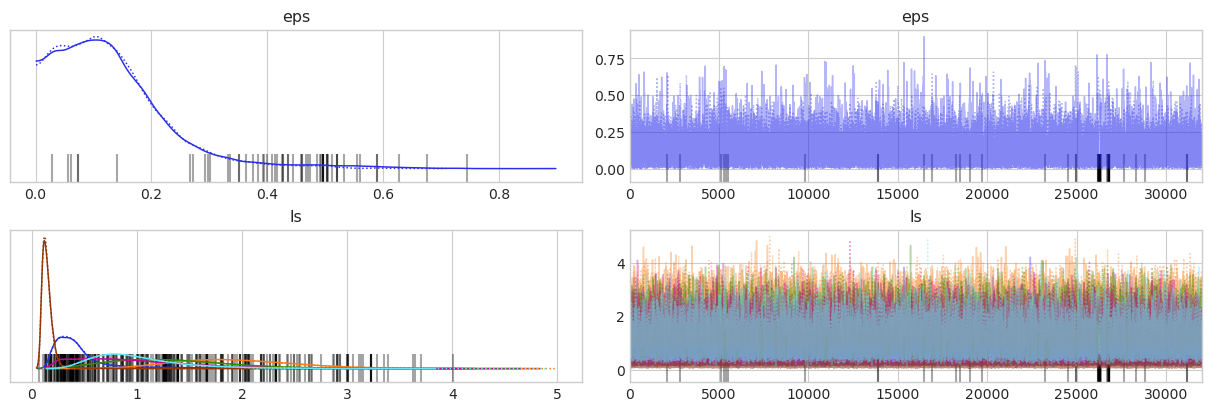

In [16]:
plot_trace(trace, ['eps', 'ls'])

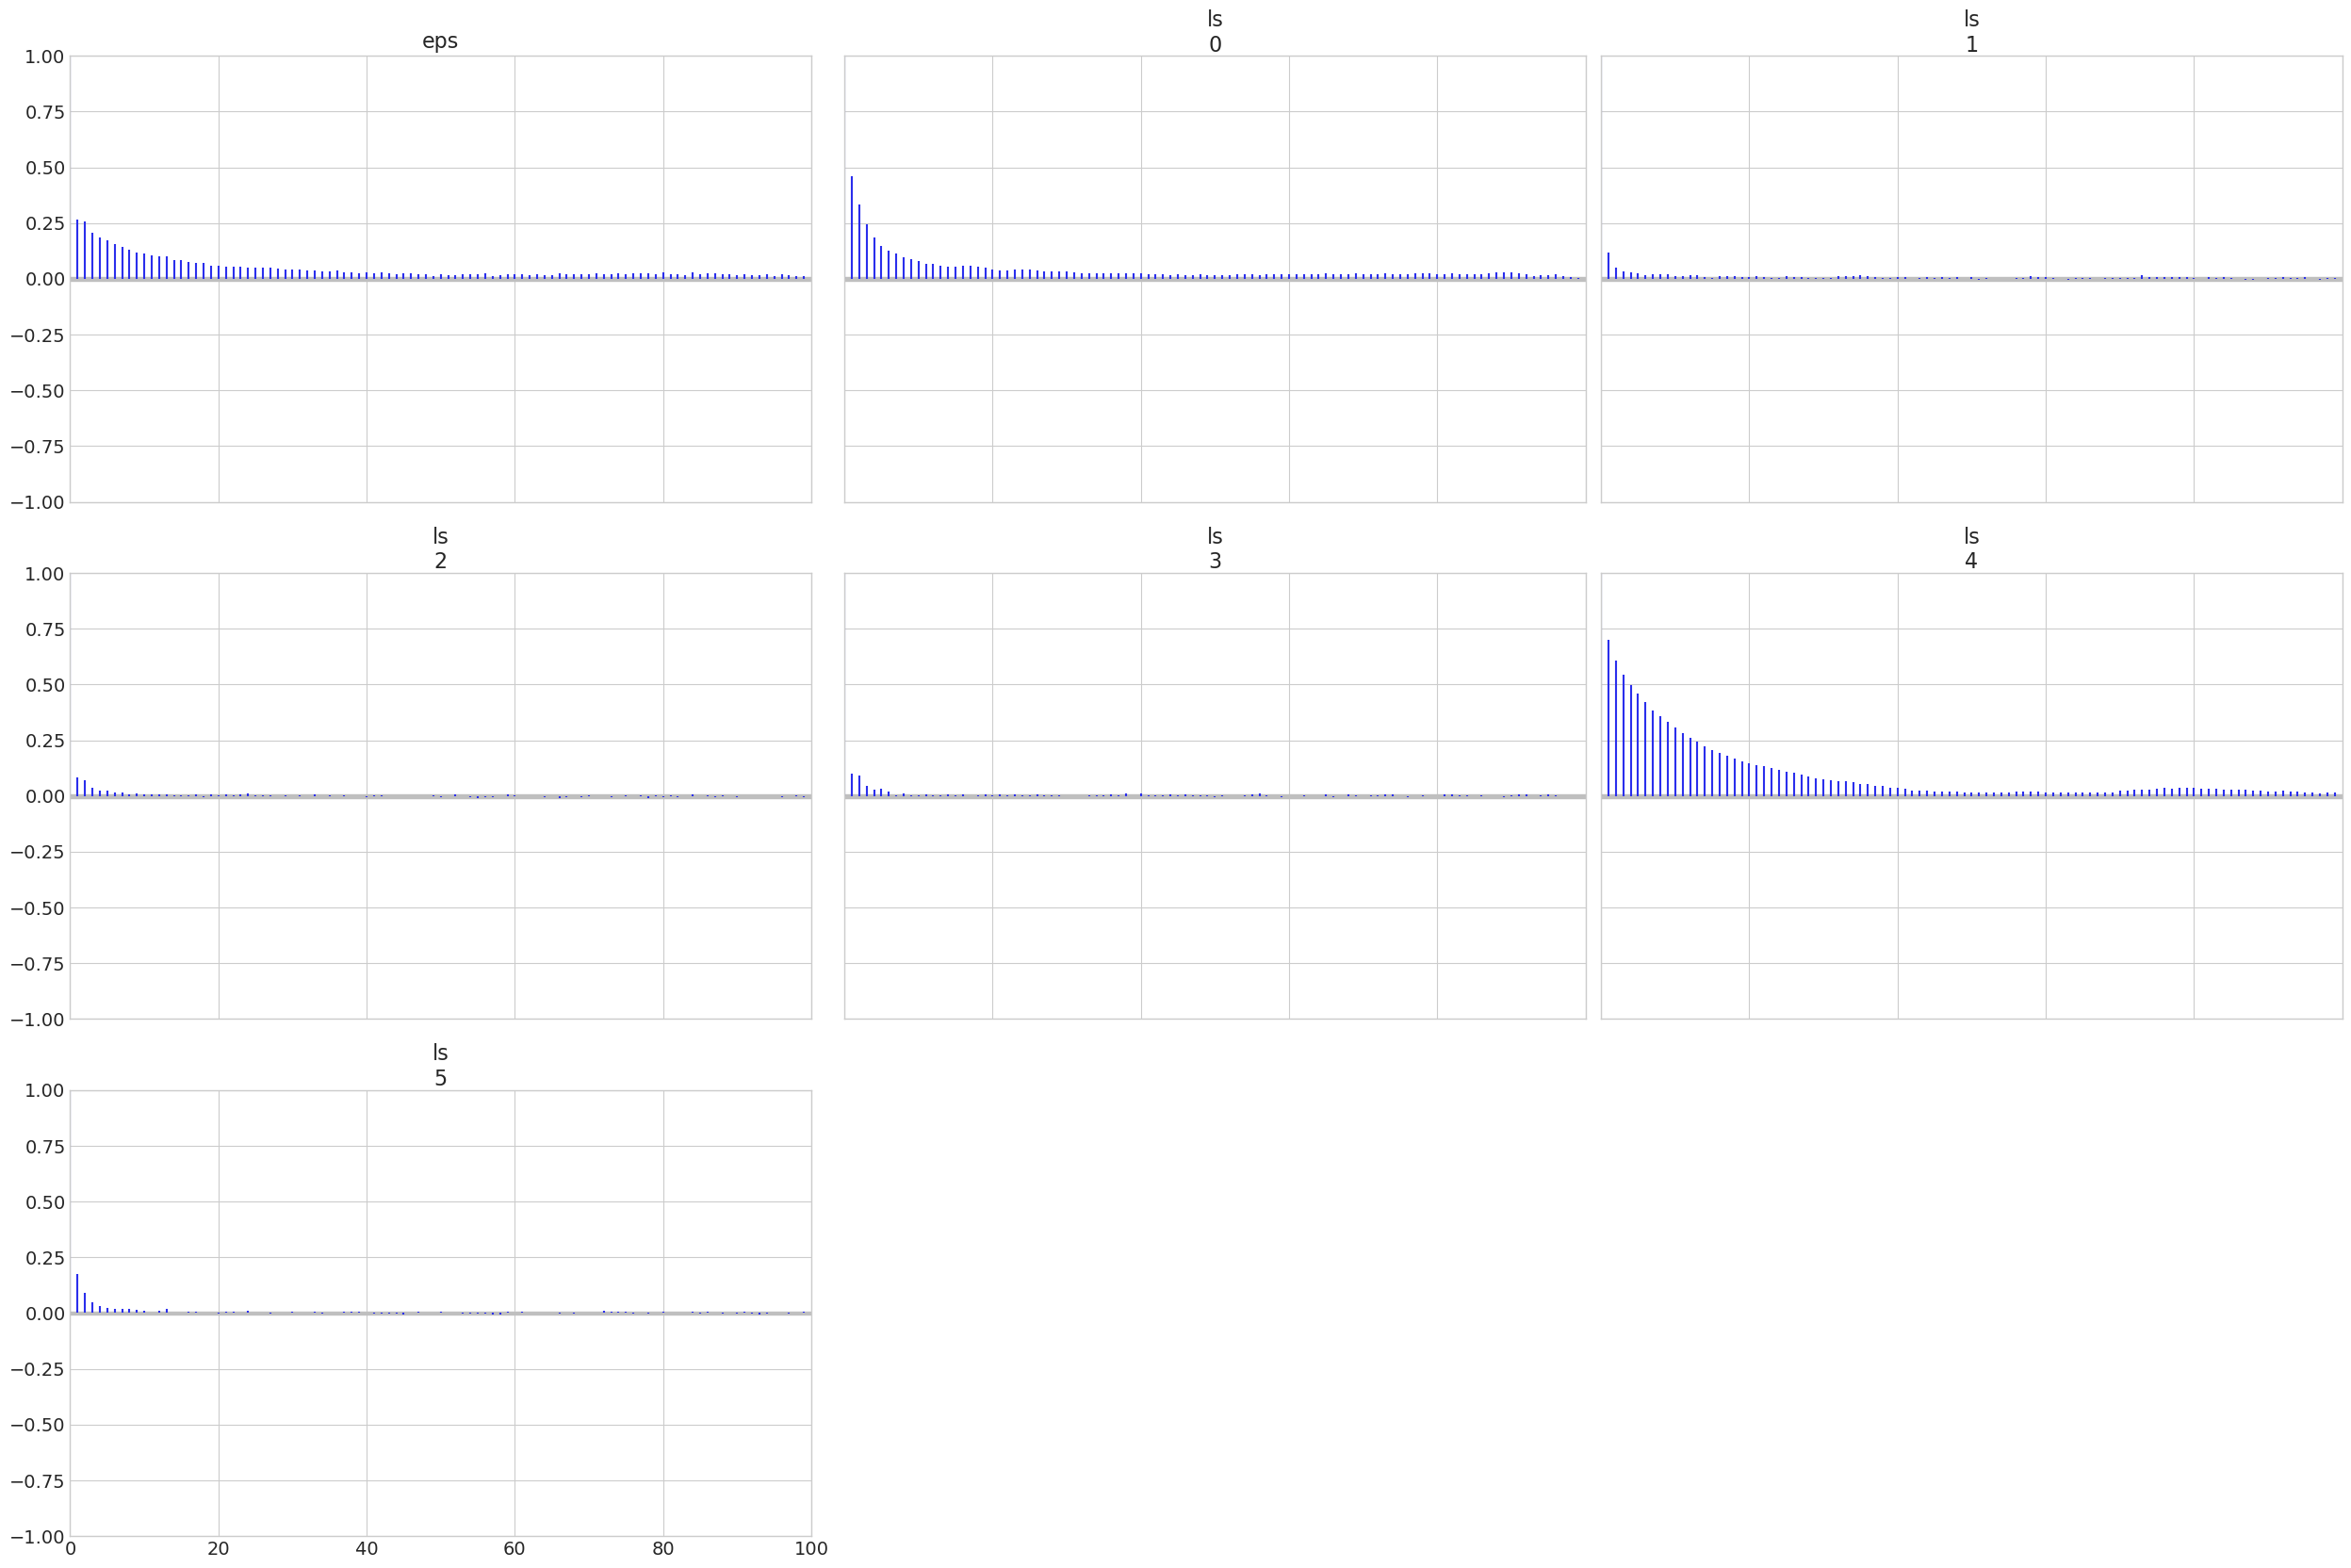

In [17]:
az.plot_autocorr(trace, var_names=['eps', 'ls'], combined=True)
plt.show()

In [18]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


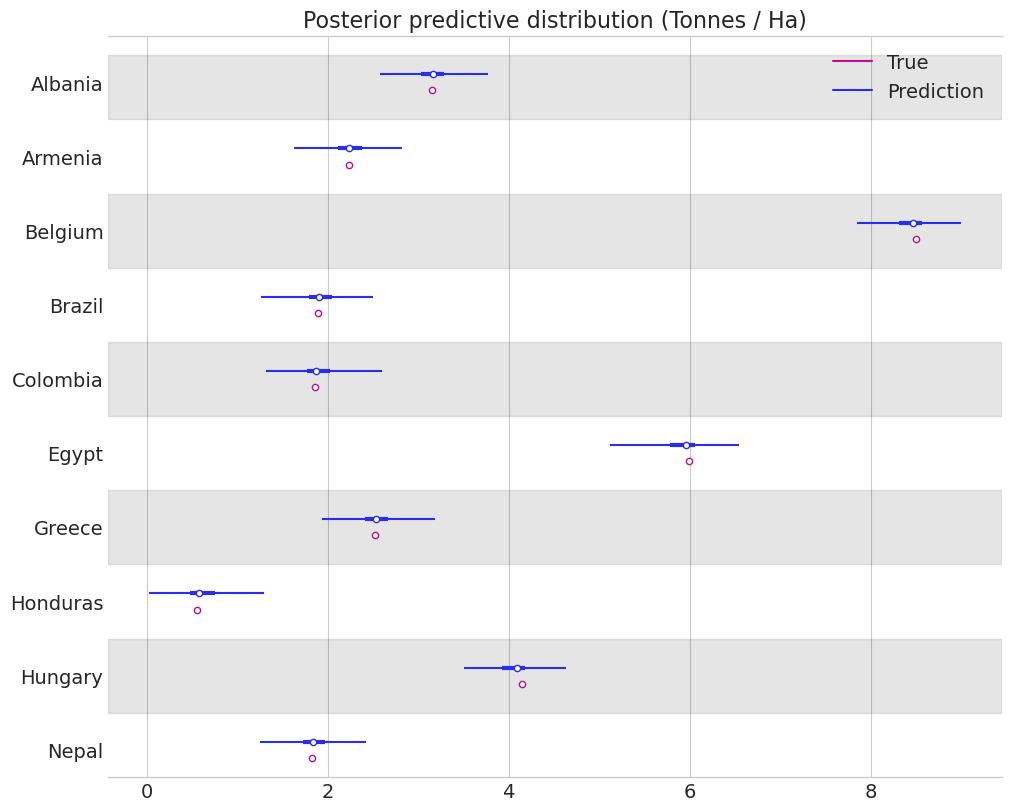

In [19]:
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices])

In [8]:
mae= compute_mae(pred_samples, y_mean, y_stddev, y_data)
print("MAE: {:.4f} (Tonnes / Ha)".format(mae * 1e-4))

MAE: 0.0185 (Tonnes / Ha)


[]

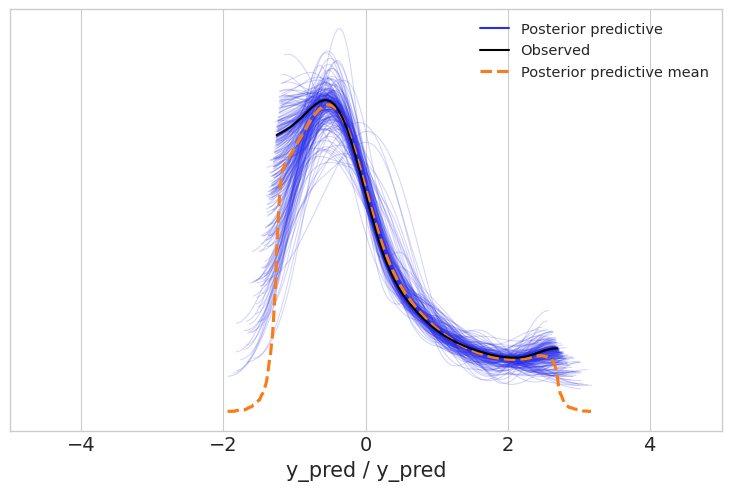

In [21]:
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
ax = az.plot_ppc(ppc_data, num_pp_samples=256)
ax.set_xlim((-5, 5))
plt.plot()

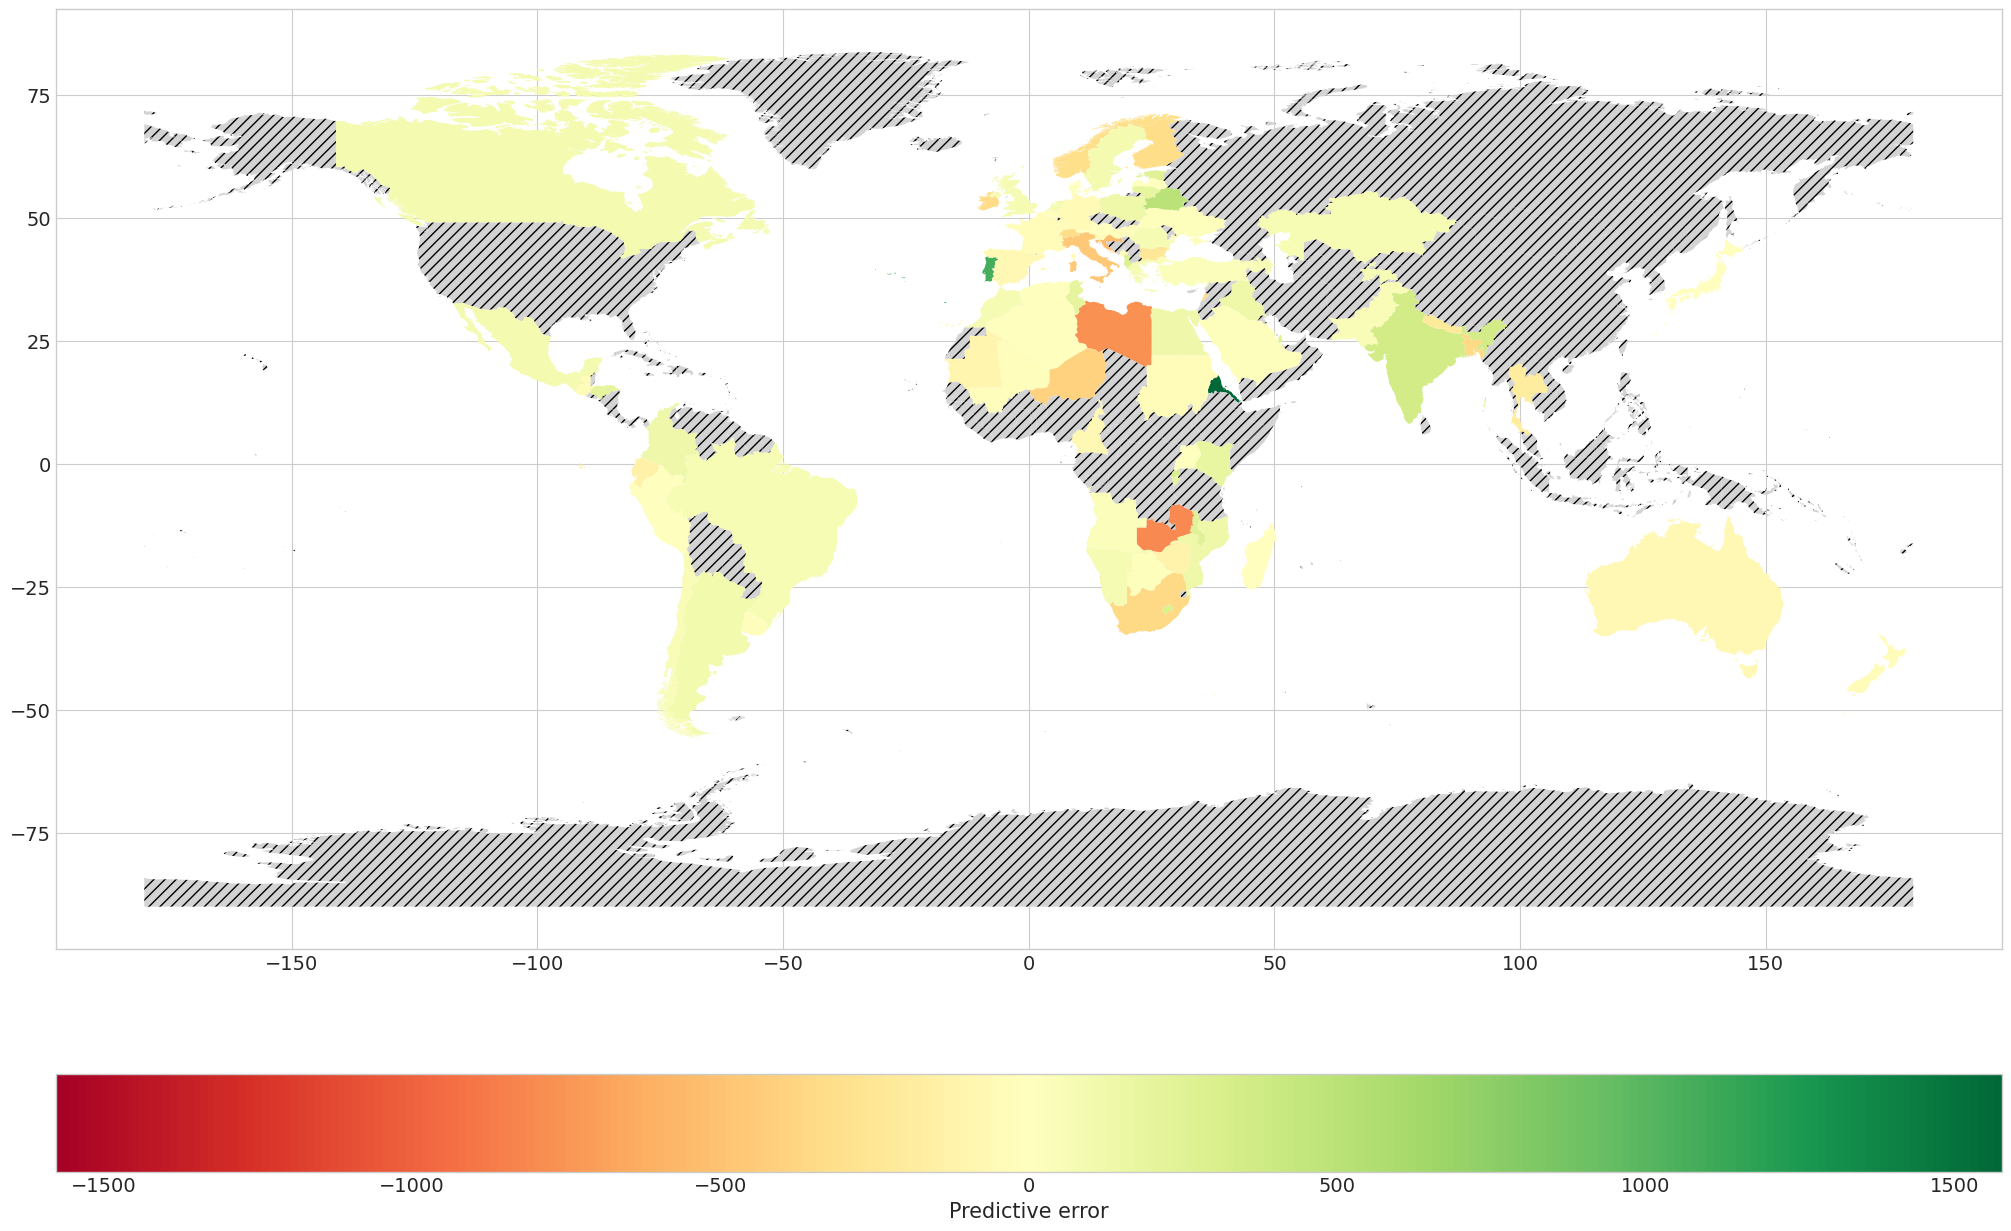

In [22]:
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data)

In [23]:
results['expquad'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## Polynomial kernel, grade 2

In [18]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    offset = pm.Normal('offset', 0, 8)
    c = pm.Normal('c', 0, 8, shape=n_features)
    grade = 2
    # Instantiate the covariance function
    cov = pm.gp.cov.Polynomial(n_features, c=c, d=grade, offset=offset) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [19]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=16_000, tune=8_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, c, offset]


Sampling 2 chains for 8_000 tune and 16_000 draw iterations (16_000 + 32_000 draws total) took 2828 seconds.
There were 13919 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8354897898402874, but should be close to 0.9. Try to increase the number of tuning steps.
There were 26537 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<font size=5>
Also with Wheat Polynomial kernel did not converge

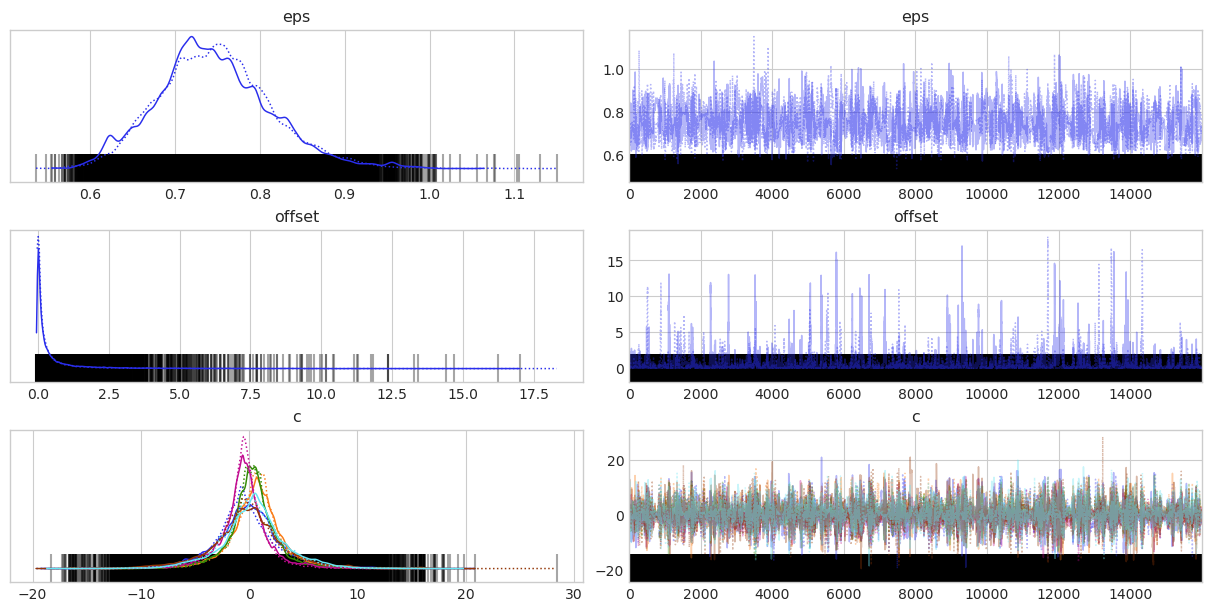

In [20]:
plot_trace(trace, ['eps', 'offset', 'c'])

<font size=5>
In addition we are not able to sample from the conditional as the matrix is not positive definite

In [21]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred')
plot_test(pred_samples[test_indices].T, y_mean, y_stddev,
          y_test_data, countries[test_indices])

C:\Users\pasqu\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


LinAlgError: Matrix is not positive definite

In [23]:
results['poly'] = {
    'trace': trace,
    # 'pred_samples': None,
    # 'mae': None,
    # 'r2': None,
}

## Exponential Kernel
<font size=5>
    Same model but with different kernel

In [46]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    # Instantiate the covariance function
    cov = pm.gp.cov.Exponential(n_features, ls) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [25]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True, target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 2177 seconds.


<br><br>
<font size=5>
Comparison of noises:
    
<font size=5>
Exponential kernel:

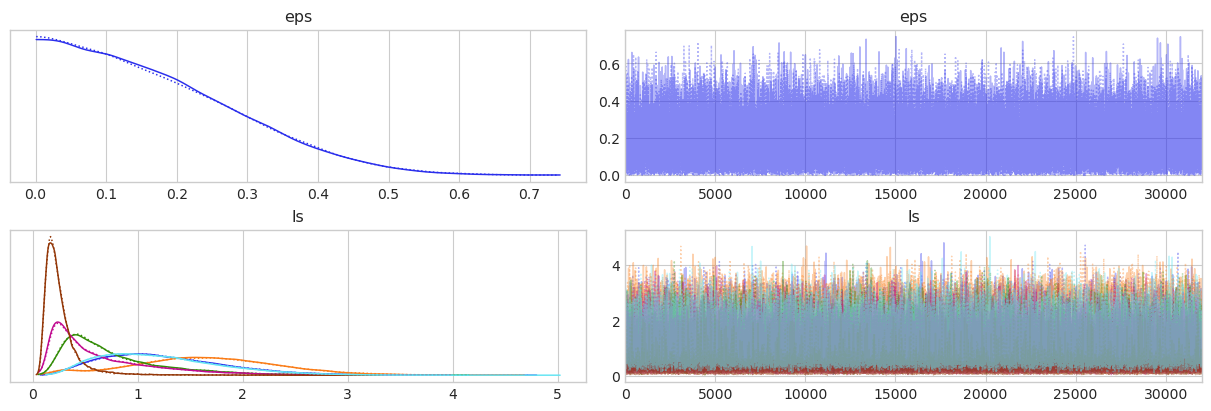

In [26]:
plot_trace(trace, ['eps', 'ls'])

<font size=5>
Exponential Quadratic kernel:

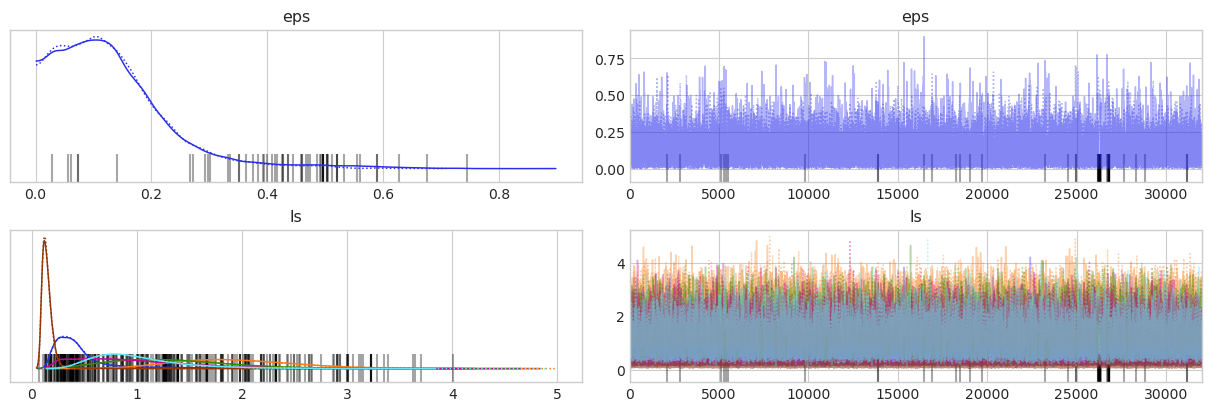

In [14]:
plot_trace(results['expquad']['trace'], ['eps', 'ls'])

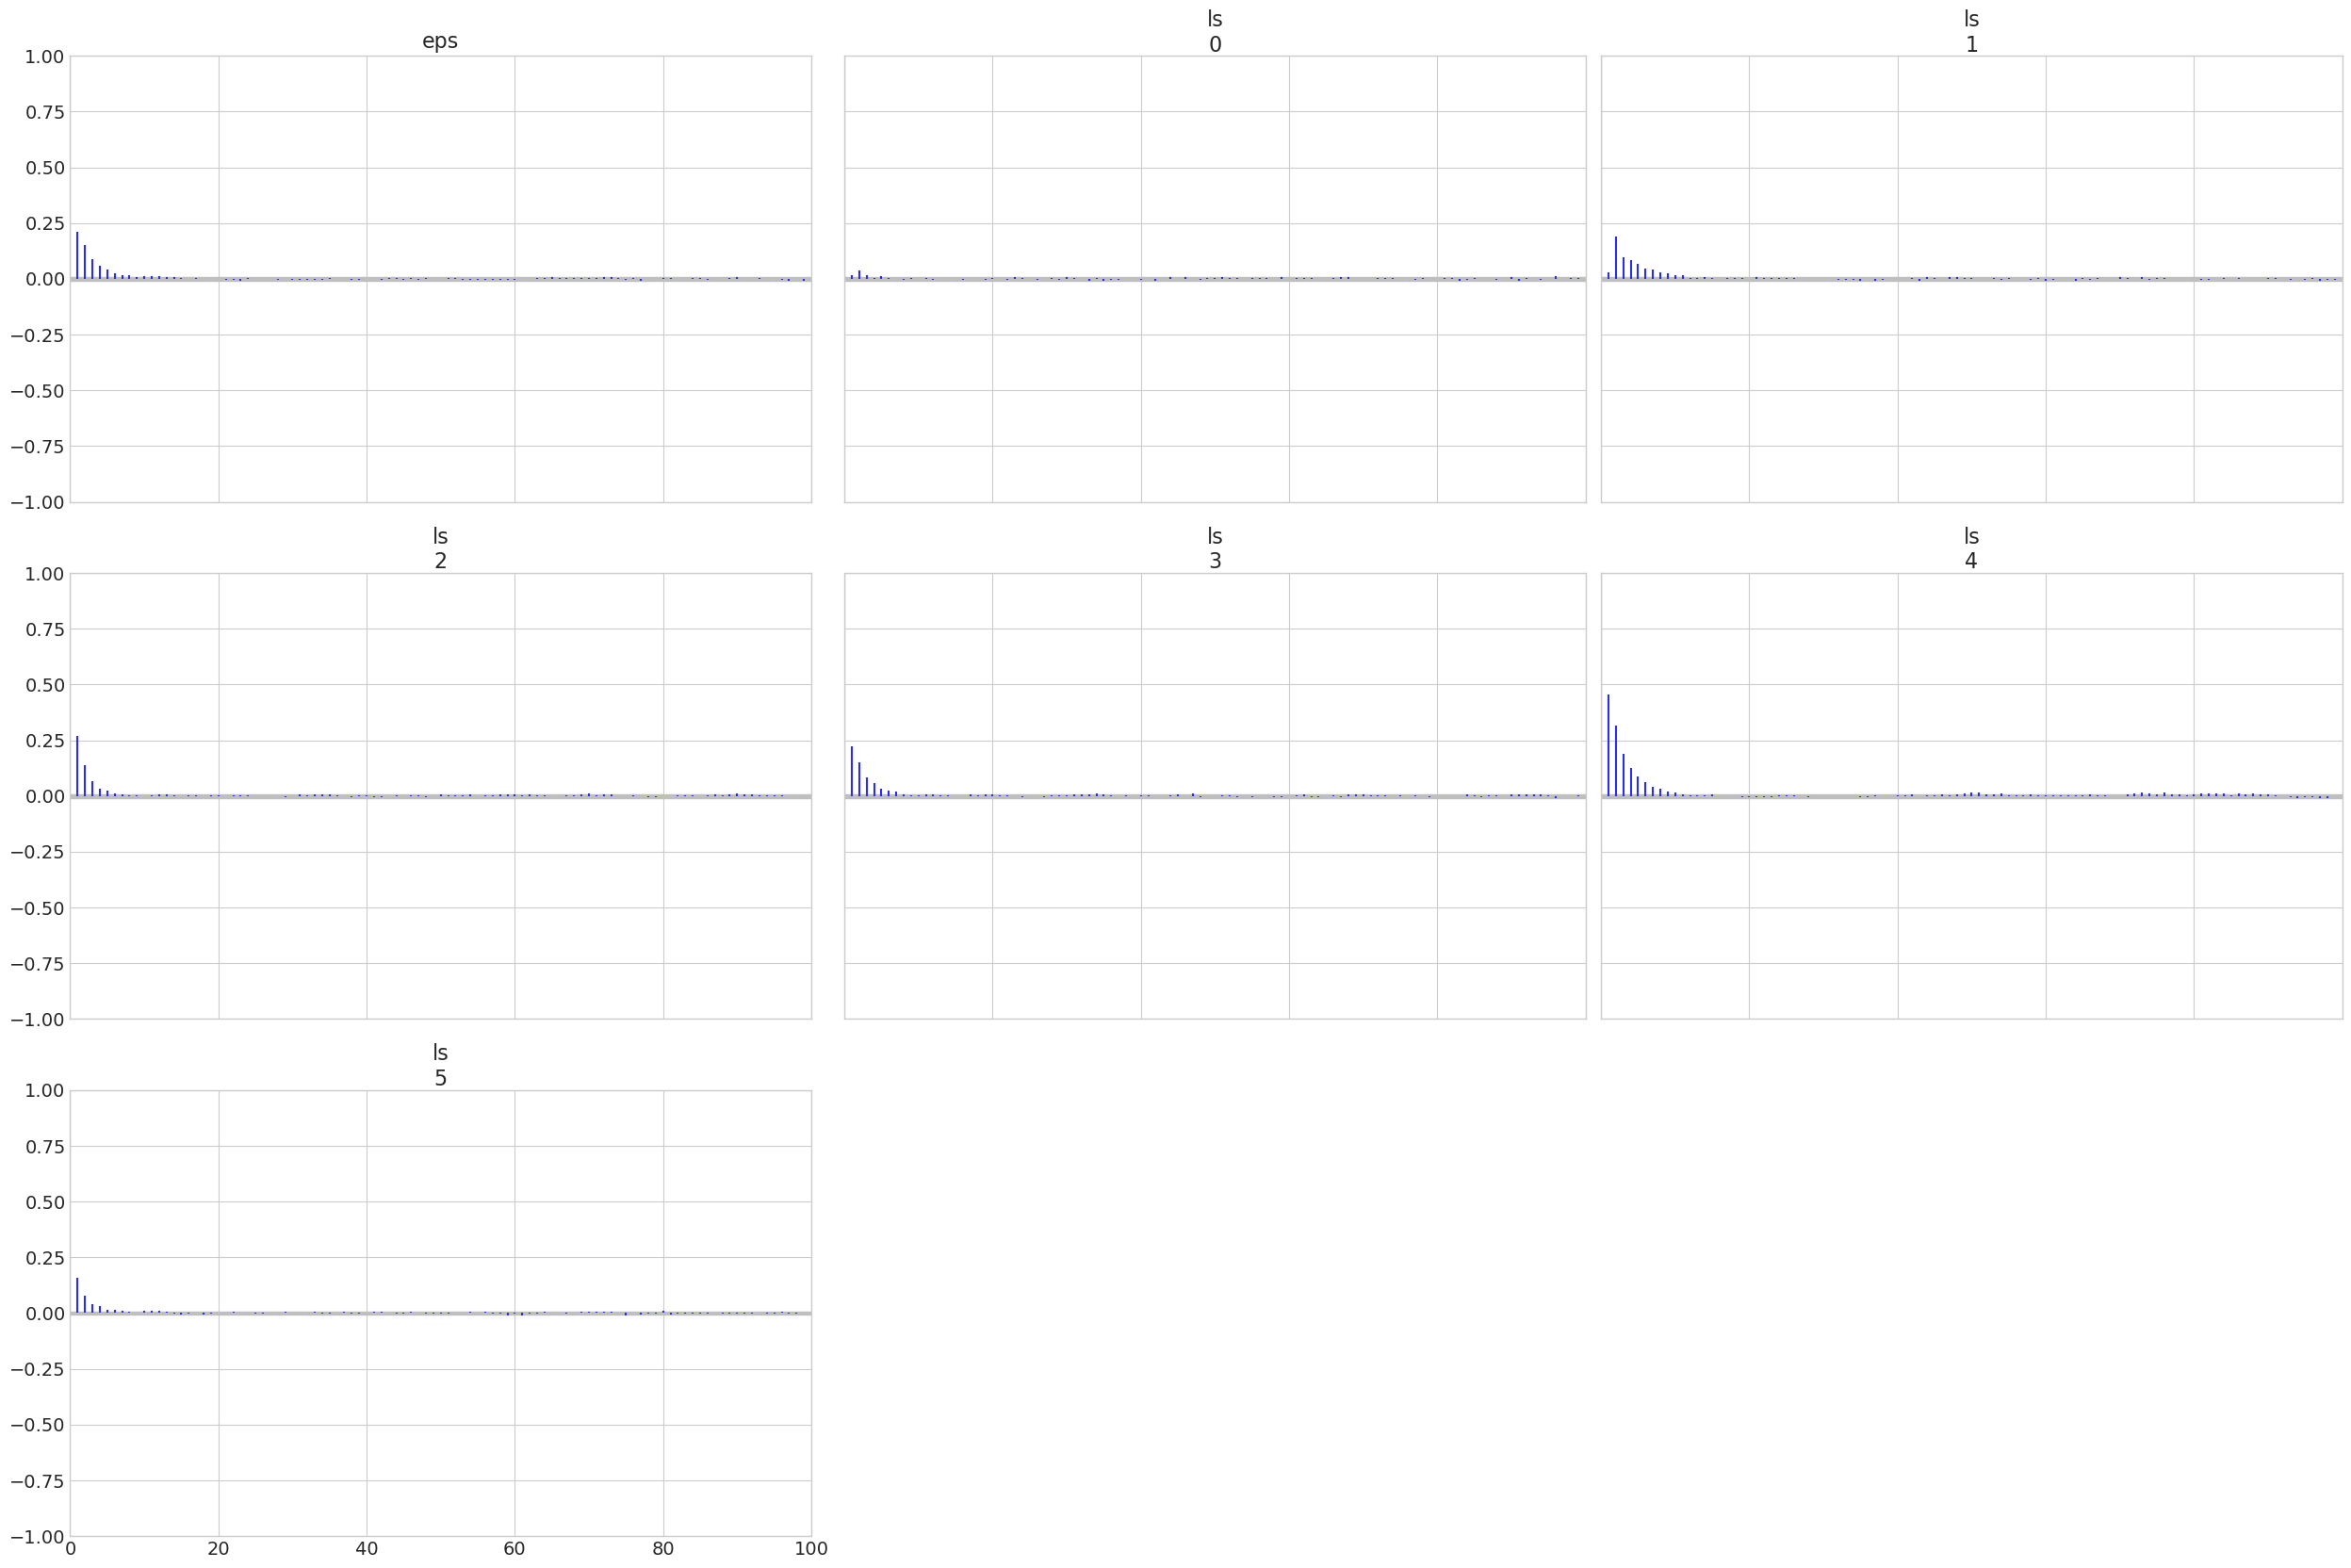

In [27]:
az.plot_autocorr(trace, var_names=['eps', 'ls'], combined=True)
plt.show()

In [30]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


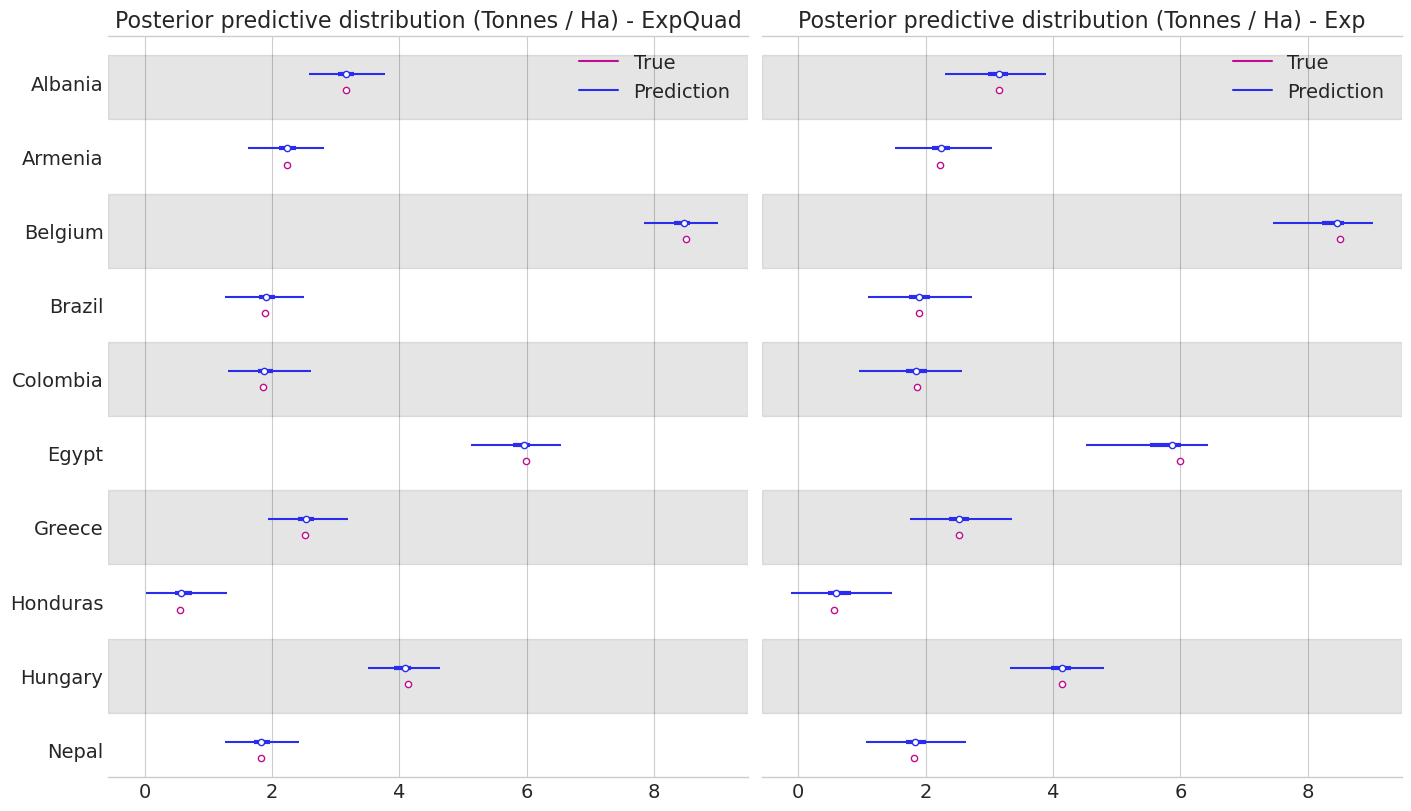

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['expquad']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - ExpQuad')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - Exp')
plt.show()

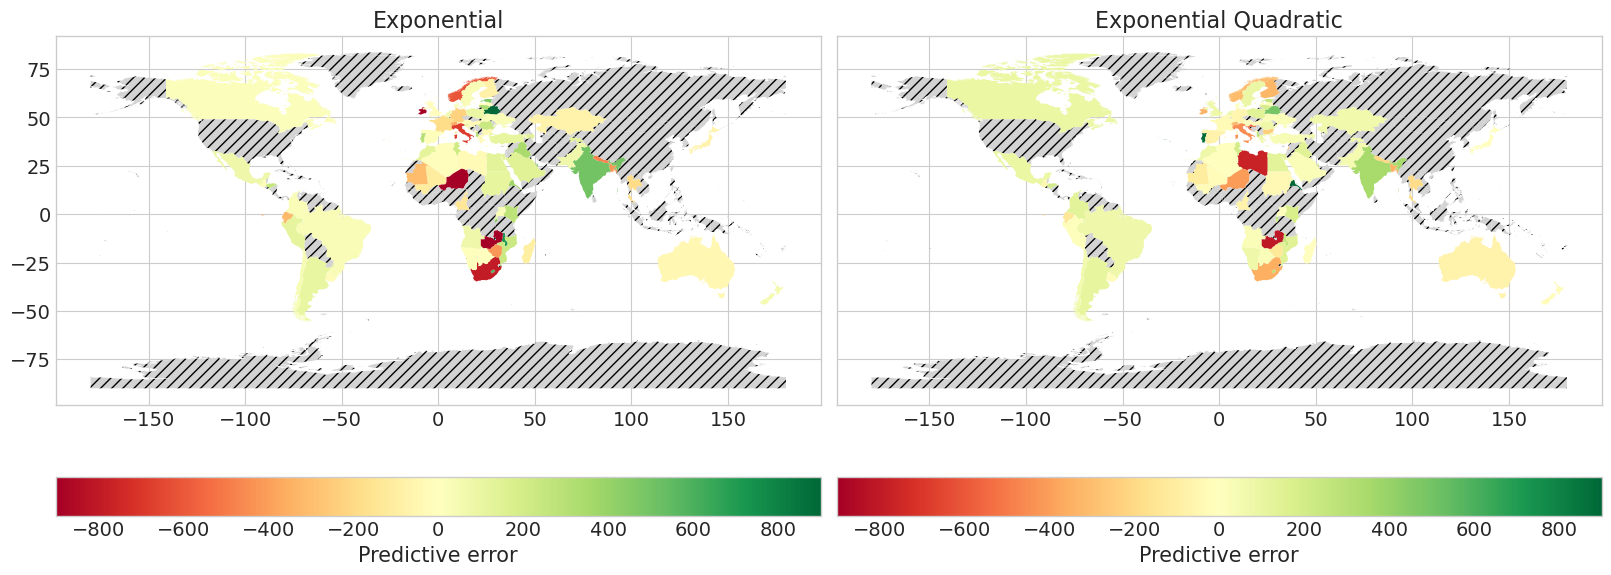

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
world_error_plot(world, results['expquad']['pred_samples'], y_mean, y_stddev, y_data, axes=ax2, max_error=900)
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data, axes=ax1, max_error=900)

<font size=5>
They make errors on different countries
    <br><br>

In [10]:
mae = compute_mae(pred_samples, y_mean, y_stddev, y_data)
print("ExpQuad MAE: {:.4f} (Tonnes / Ha)".format(results['expquad']['mae'] * 1e-4))
print("Exp     MAE: {:.4f} (Tonnes / Ha)".format(mae * 1e-4))

ExpQuad MAE: 0.0185 (Tonnes / Ha)
Exp     MAE: 0.0236 (Tonnes / Ha)


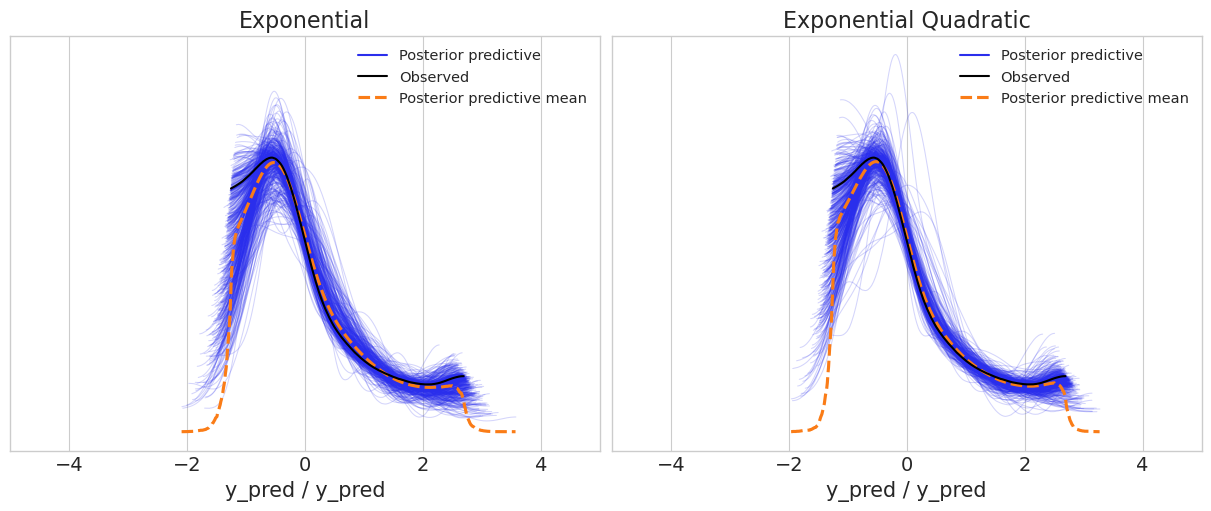

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['expquad']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax2)
ax2.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

In [32]:
results['exp'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## RatQuad Kernel

In [4]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 0.5, shape=n_features)
    alpha = pm.Normal('alpha', 0, 0.5)
    # Instantiate the covariance function
    cov = pm.gp.cov.RatQuad(n_features, ls=ls, alpha=alpha) + pm.gp.cov.WhiteNoise(1e-5)
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [5]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True, target_accept=0.95
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, alpha, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 5107 seconds.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
There were 462 divergences after tuning. Increase `target_accept` or reparameterize.


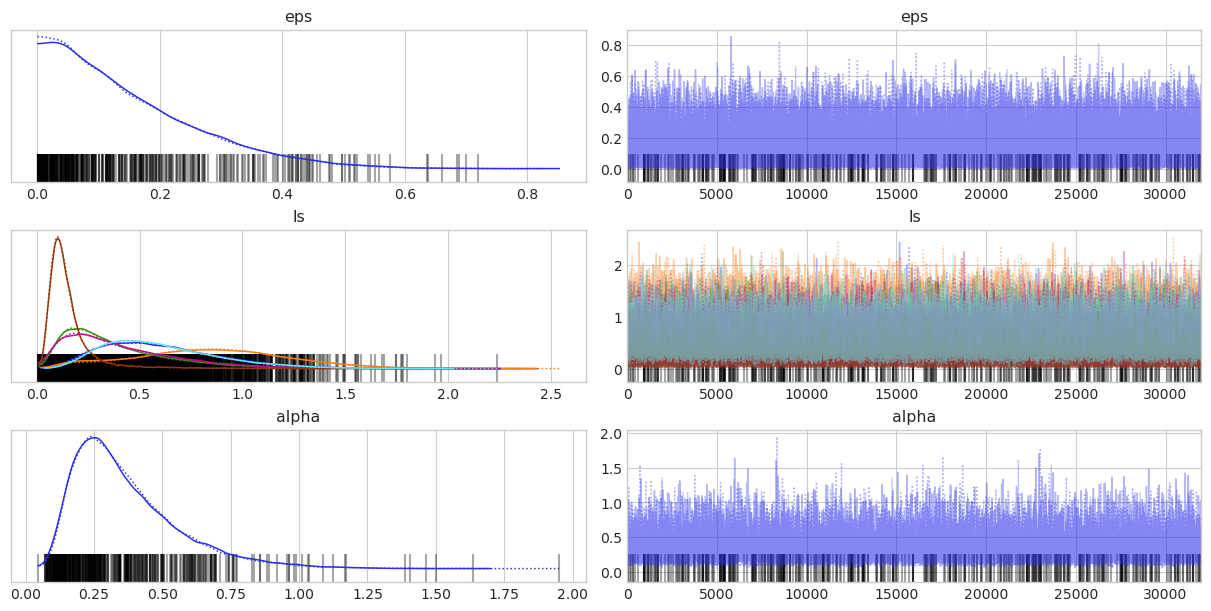

In [6]:
plot_trace(trace, ['eps', 'ls', 'alpha'])

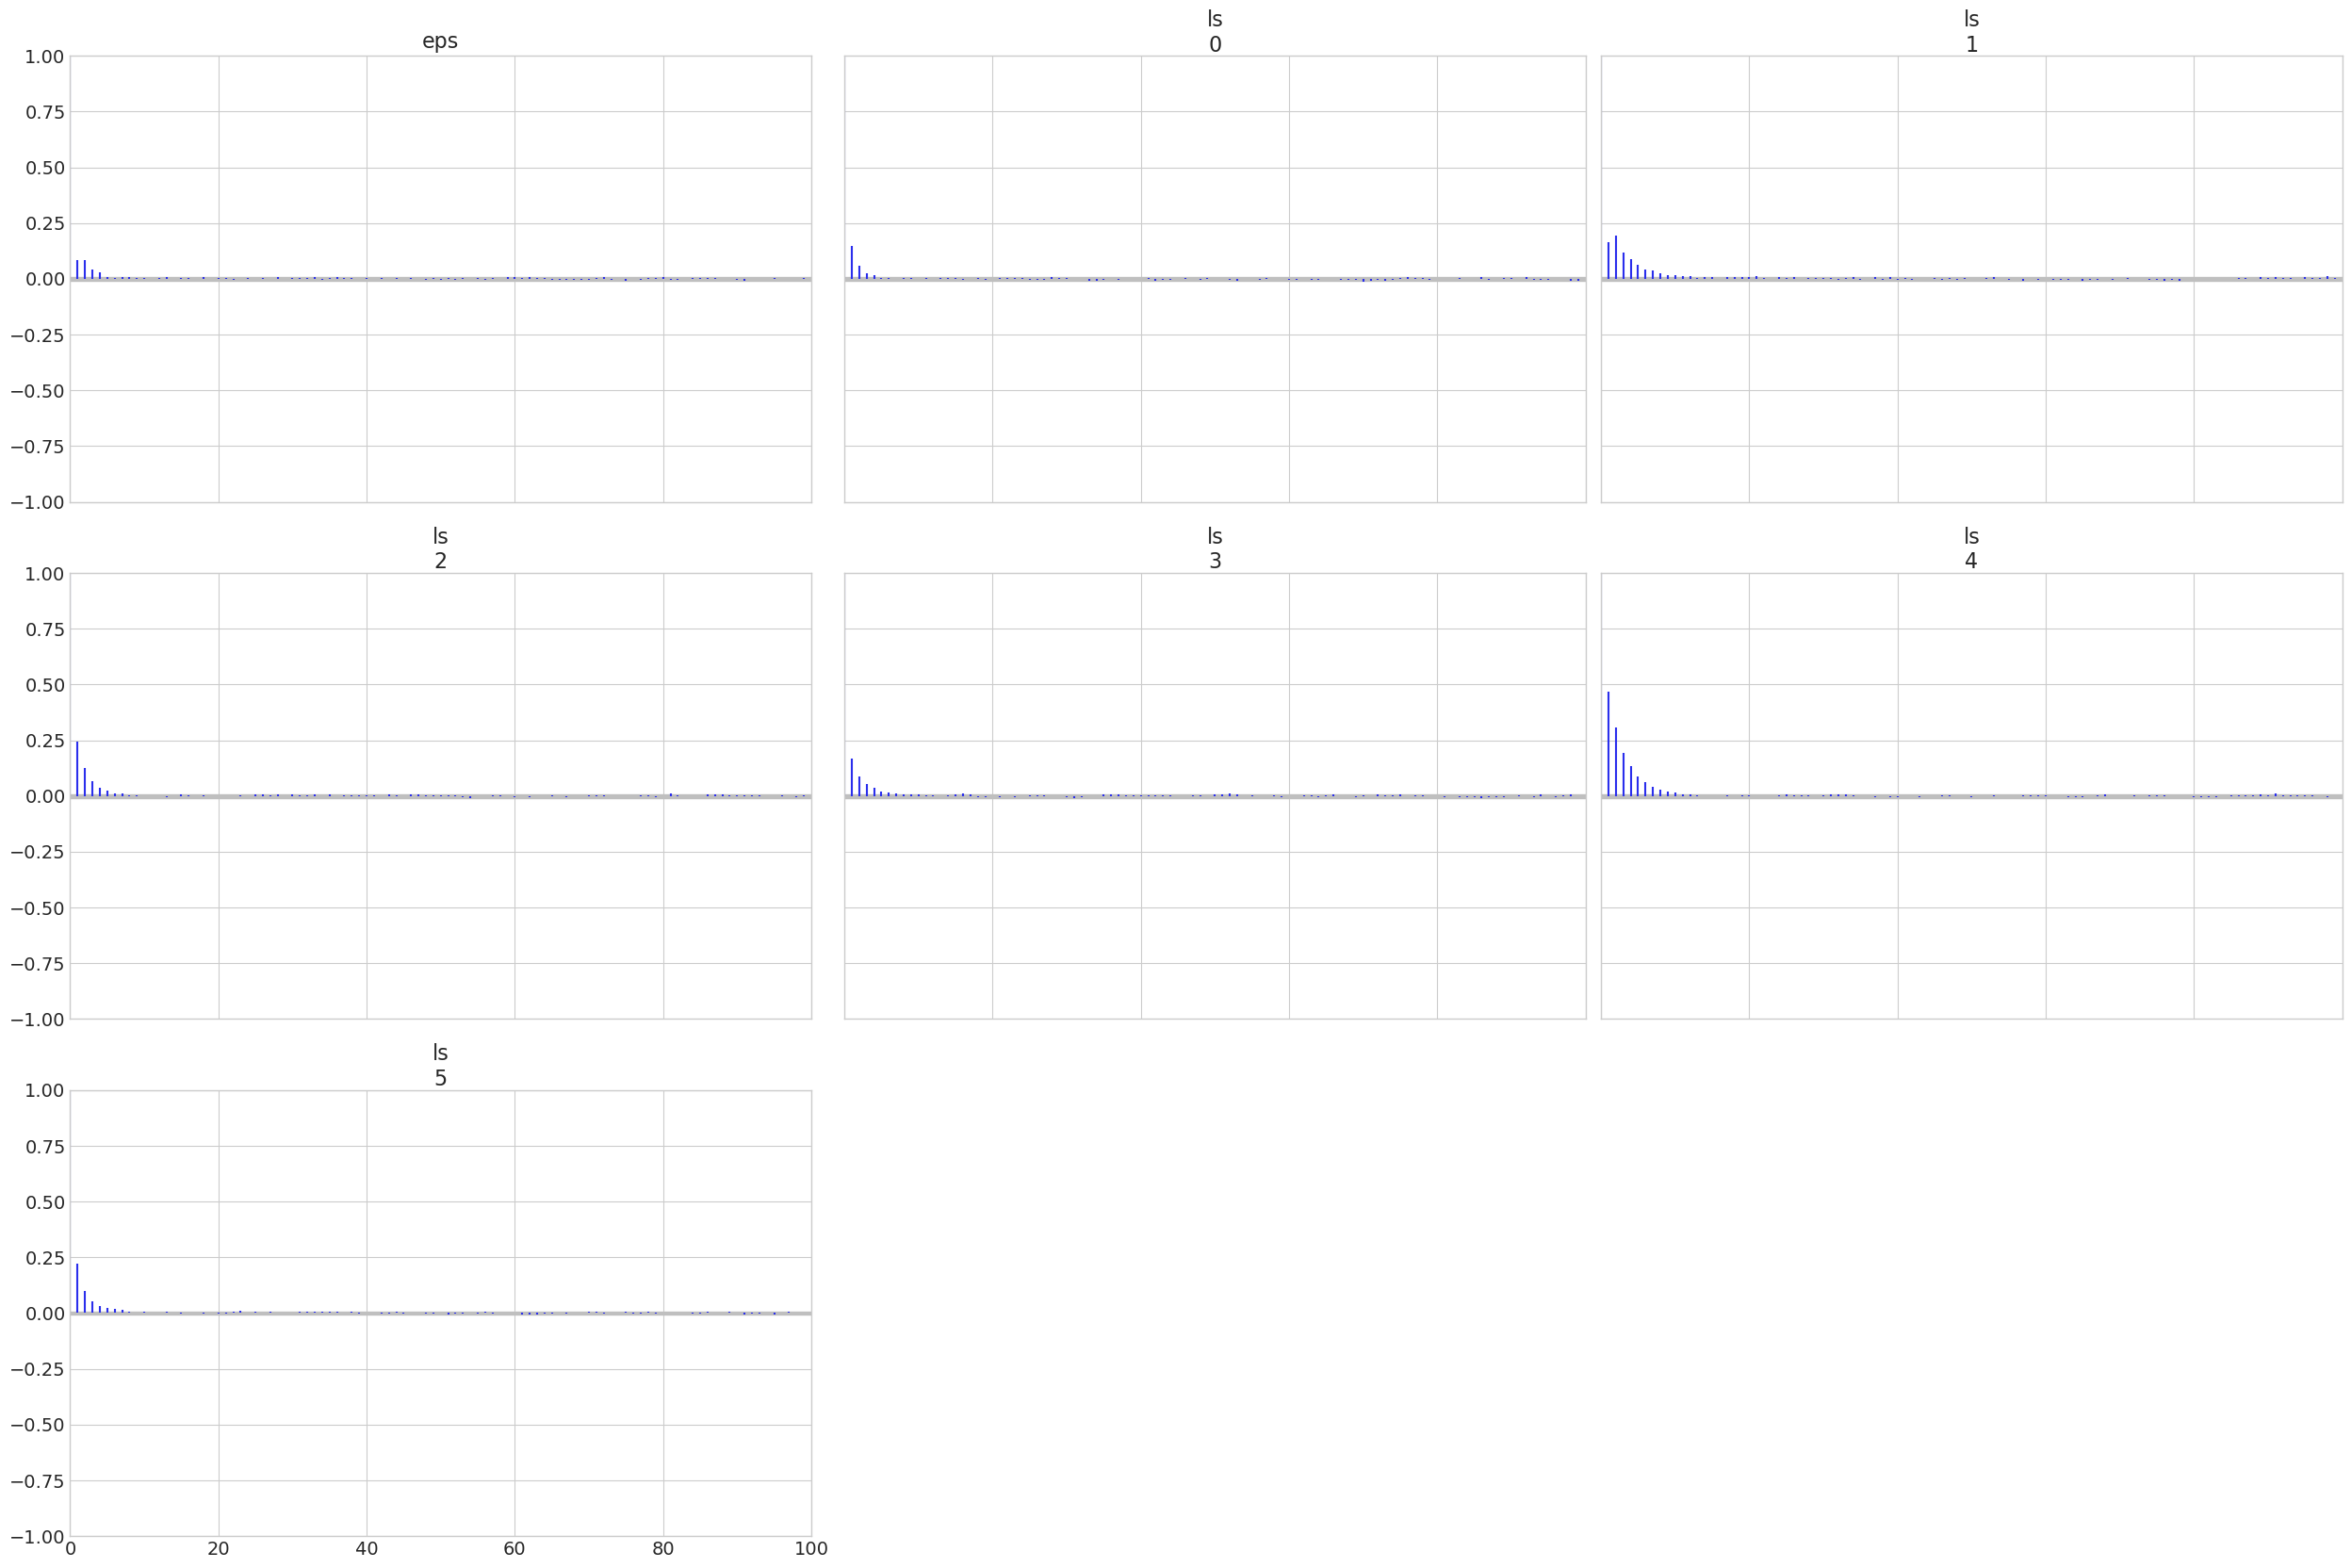

In [7]:
az.plot_autocorr(trace, var_names=['eps', 'ls'], combined=True)
plt.show()

In [8]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\pasqu\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


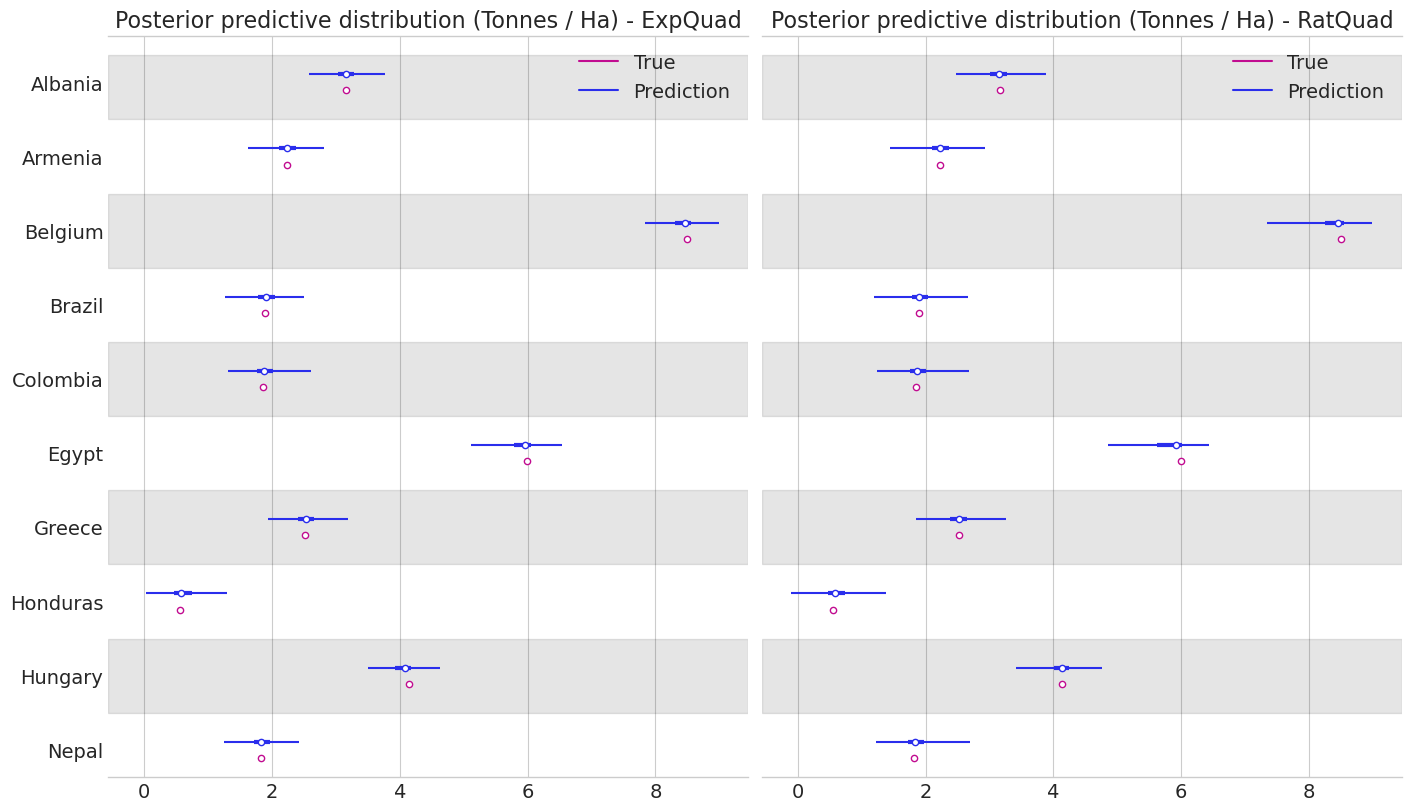

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['expquad']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - ExpQuad')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - RatQuad')
plt.show()

<font size=5>
Also here, RatQuad have slighty more wide distributions
    <br><br>

In [13]:
mae = compute_mae(pred_samples, y_mean, y_stddev, y_data)
print("ExpQuad MAE: {:.4f} (Tonnes / Ha)".format(results['expquad']['mae'] * 1e-4))
print("Exp     MAE: {:.4f} (Tonnes / Ha)".format(results['exp']['mae'] * 1e-4))
print("RatQuad MAE: {:.4f} (Tonnes / Ha)".format(mae * 1e-4))

ExpQuad MAE: 0.0185 (Tonnes / Ha)
Exp     MAE: 0.0267 (Tonnes / Ha)
RatQuad MAE: 0.0165 (Tonnes / Ha)


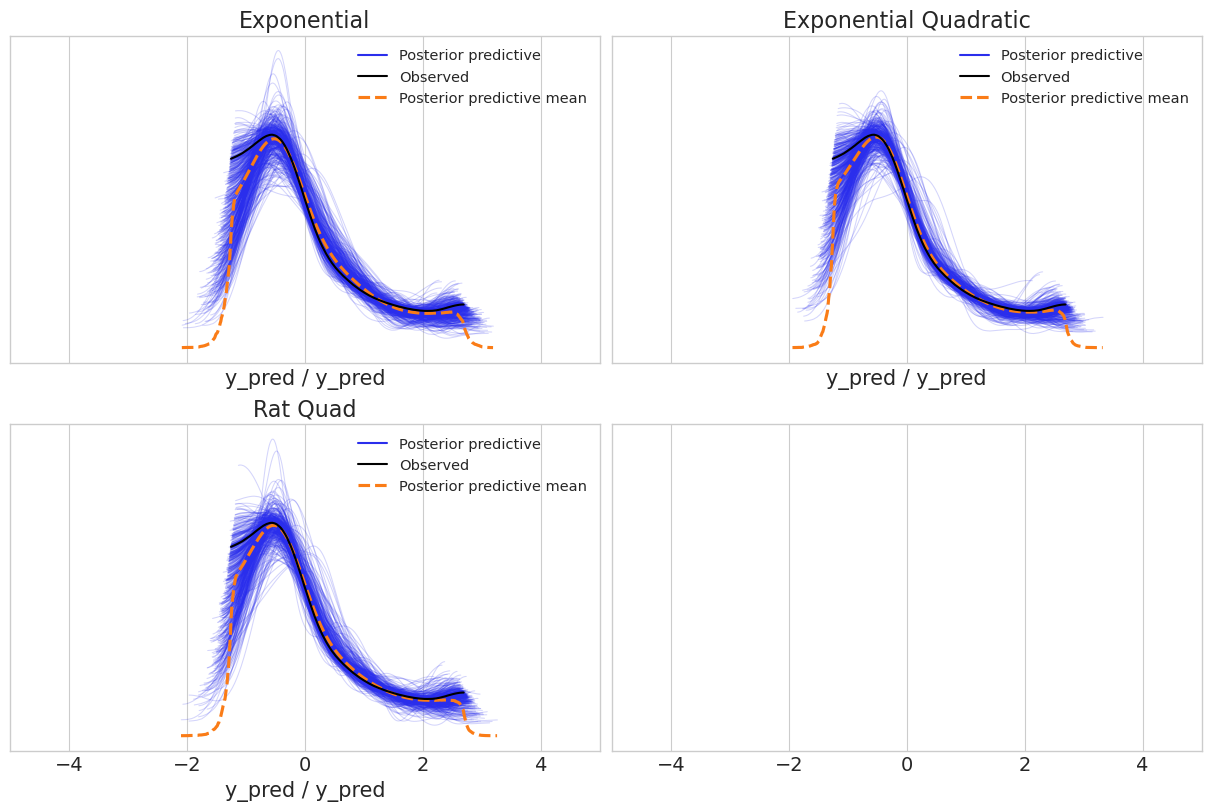

In [13]:
fig, ((ax1, ax2), (ax3, _)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), sharex=True, sharey=True)
ax1.set_title('Exponential')
ax2.set_title('Exponential Quadratic')
ax3.set_title('Rat Quad')
ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['expquad']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax2)
ax2.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['exp']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=512, ax=ax3)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

In [15]:
results['ratquad'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

## Combyning kernels - weighted sum

In [35]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    c = pm.Normal('c', 0, 8, shape=n_features)
    # Instantiate the covariance function
    w0 = pm.HalfNormal('w0', 5)
    w1 = pm.HalfNormal('w1', 5)
    cov = pm.gp.cov.Exponential(n_features, ls=ls) * w0 + \
        pm.gp.cov.Linear(n_features, c=c) * w1 + \
        pm.gp.cov.WhiteNoise(1e-5) 
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [47]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, w1, w0, c, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 3592 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


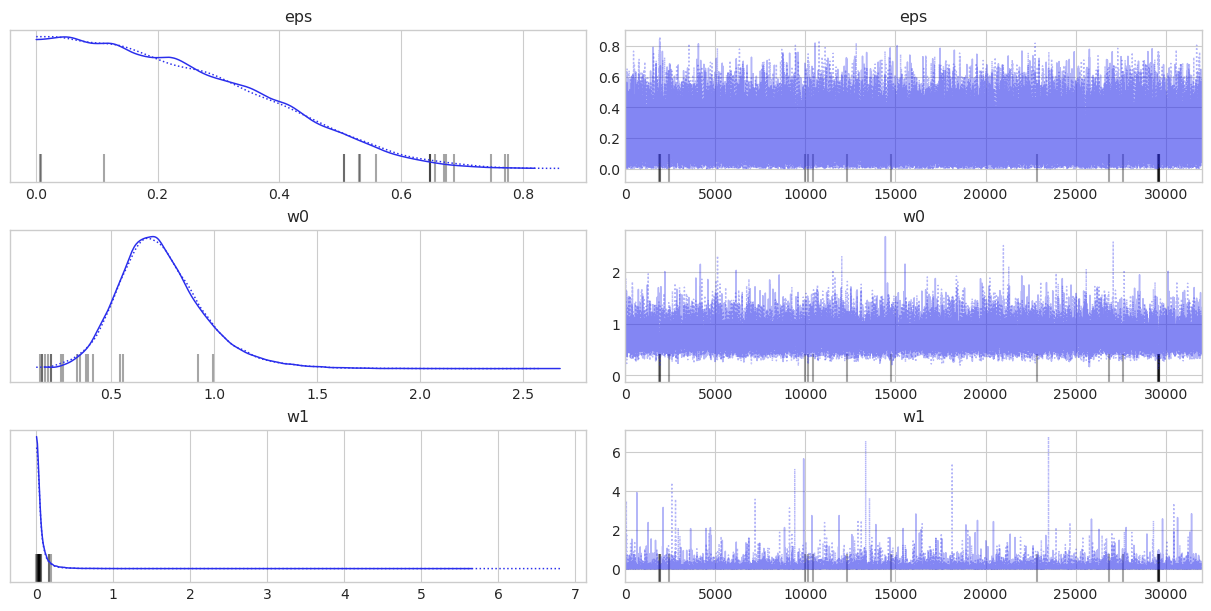

In [48]:
plot_trace(trace, ['eps', 'w0', 'w1'])

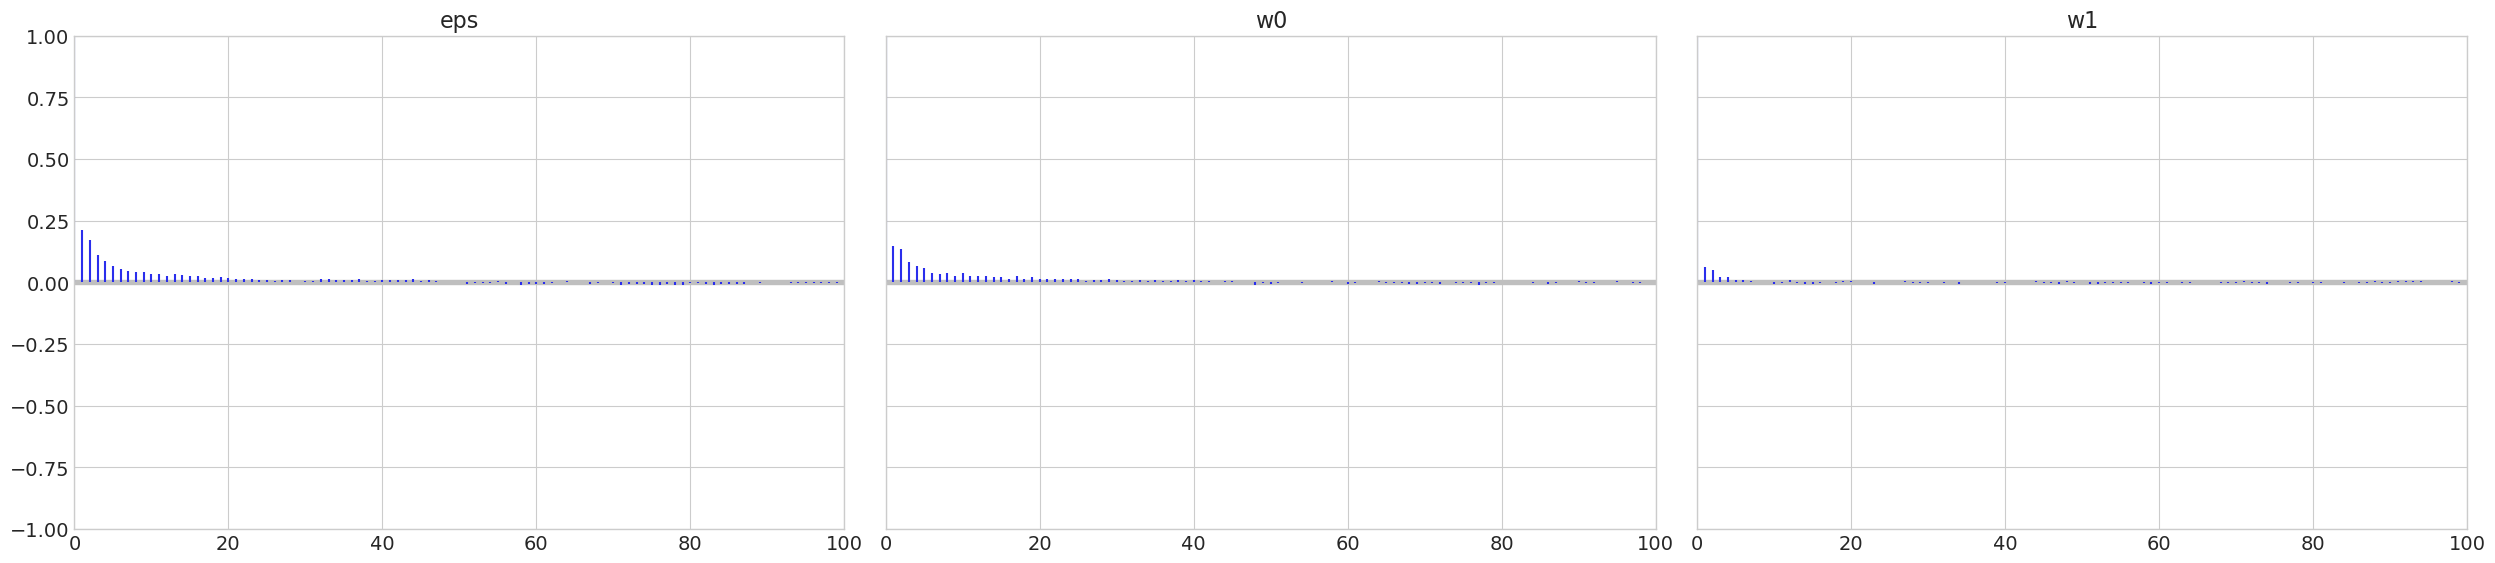

In [49]:
az.plot_autocorr(trace, var_names=['eps', 'w0', 'w1'], combined=True)
plt.show()

In [37]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\PasqualeDeMarinis\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


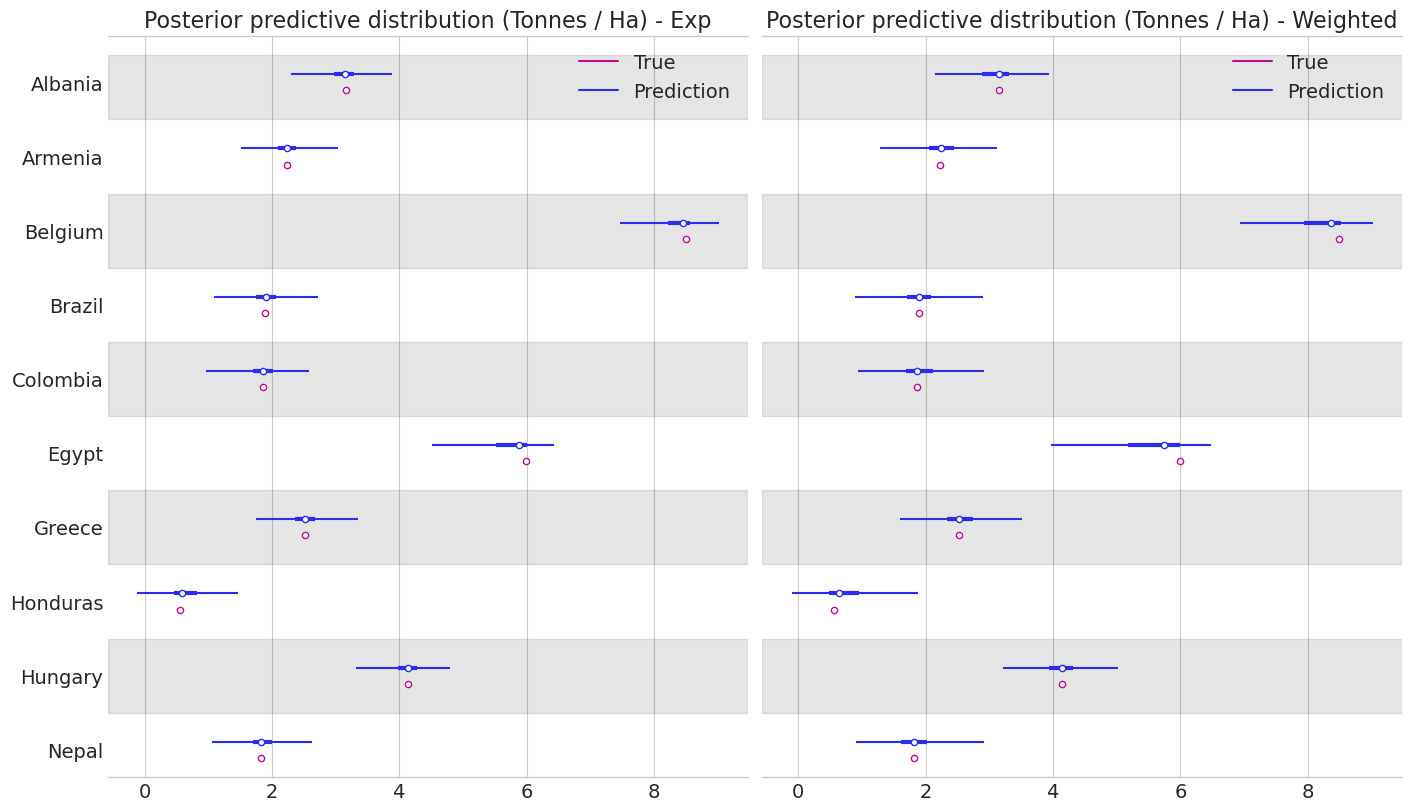

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['exp']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - Exp')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - Weighted')
plt.show()

In [15]:
mae = compute_mae(pred_samples, y_mean, y_stddev, y_data)
print("Exp      MAE: {:.4f} (Tonnes / Ha)".format(results['exp']['mae'] * 1e-4))
print("Weighted MAE: {:.4f} (Tonnes / Ha)".format(mae * 1e-4))

Exp      MAE: 0.0267 (Tonnes / Ha)
Weighted MAE: 0.0520 (Tonnes / Ha)


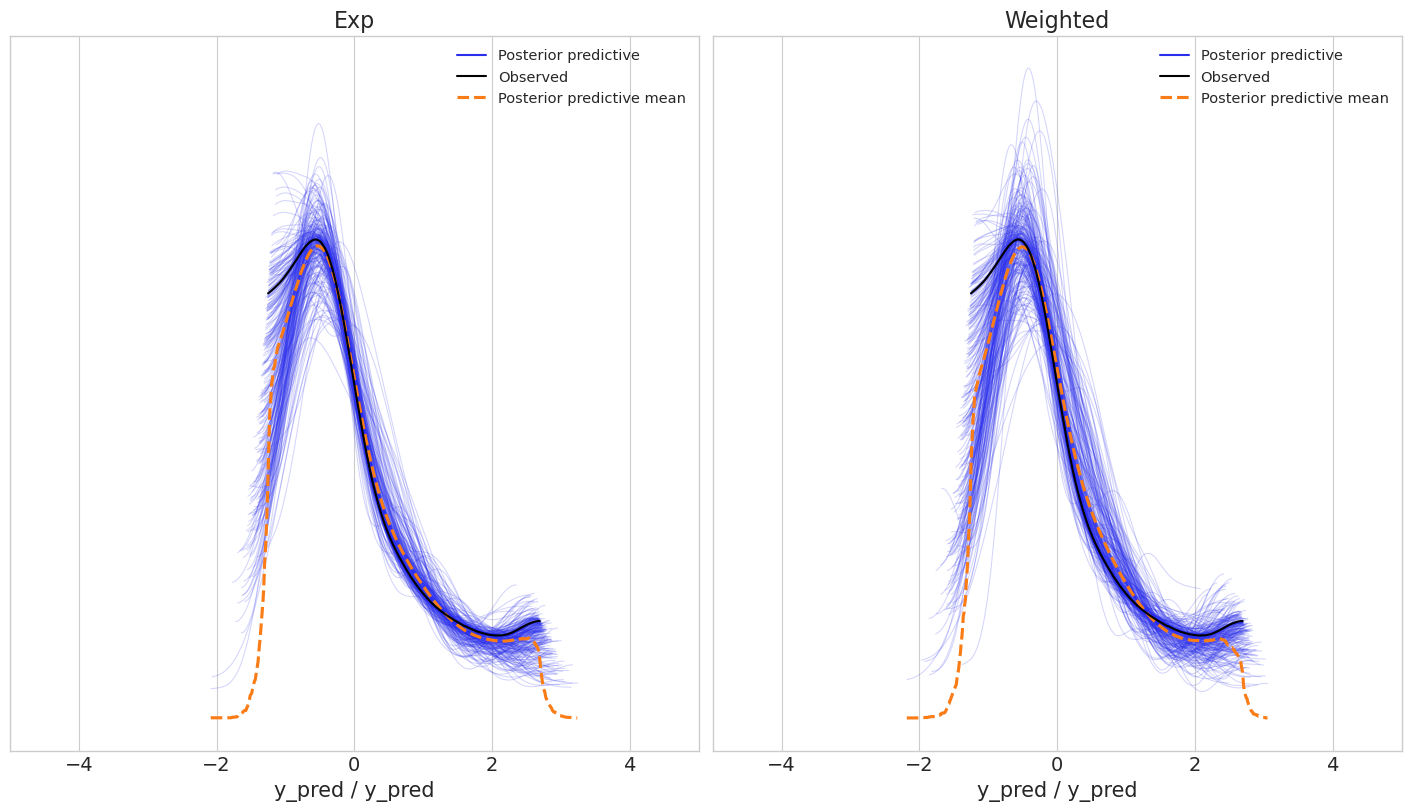

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
ax1.set_title('Exp')
ax2.set_title('Weighted')

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['exp']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax2)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

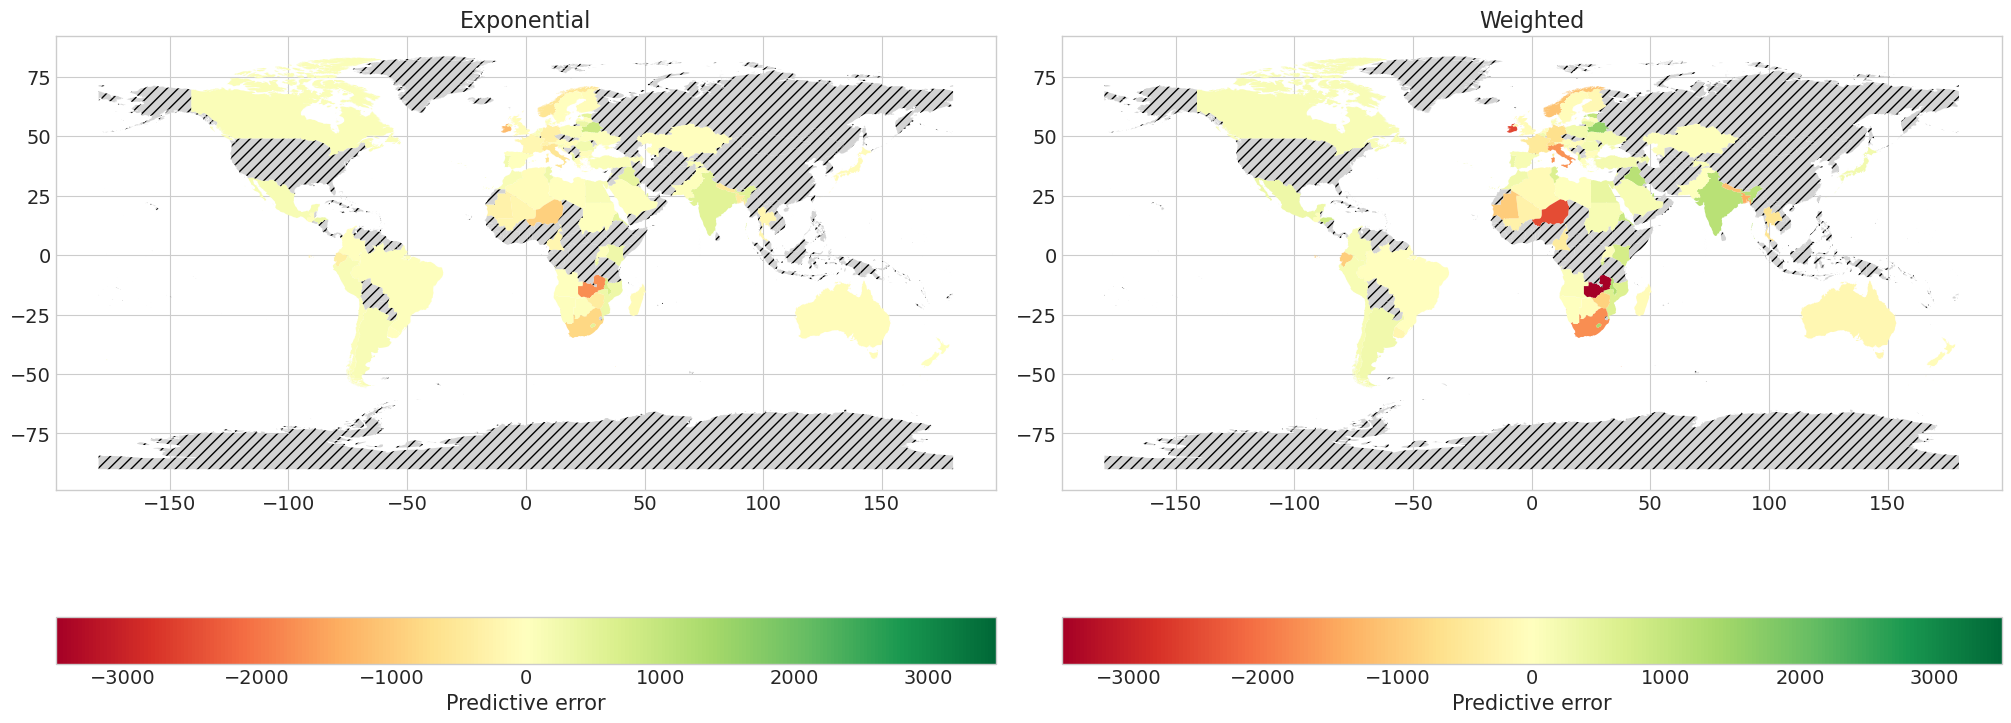

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.set_title('Exponential')
ax2.set_title('Weighted')
world_error_plot(world, results['exp']['pred_samples'], y_mean, y_stddev, y_data, axes=ax1, max_error=3500)
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data, axes=ax2, max_error=3500)
plt.show()

<font size=5>
    Also here, linear combination with Linear kernel don't give benefits

In [ ]:
results['exp_linear_weighted'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
    'r2': r2,
}

### Multiplication

In [4]:
# Build a PyMC3 GP regression model
with pm.Model() as model:
    # Instantiate a hyper-prior on the covariance function's parameter
    ls = pm.HalfNormal('ls', 1.0, shape=n_features)
    c = pm.Normal('c', 0, 8, shape=n_features)
    # Instantiate the covariance function
    cov = pm.gp.cov.Exponential(n_features, ls=ls) * \
        pm.gp.cov.Linear(n_features, c=c) + \
        pm.gp.cov.WhiteNoise(1e-5) 
    # Instantiate the GP marginal variable
    gp = pm.gp.Marginal(cov_func=cov)
    eps = pm.HalfCauchy('eps', 5.0)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=x_std_data, y=y_std_data, noise=eps)
    gp_model = GaussianProcess(model=model, gp=gp)

In [7]:
# Sample from posterior
with model:
    trace = pm.sample(
        draws=32_000, tune=16_000,
        chains=2, cores=1, random_seed=42,
        return_inferencedata=True,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, c, ls]


Sampling 2 chains for 16_000 tune and 32_000 draw iterations (32_000 + 64_000 draws total) took 1928 seconds.


<font size=5>
Comparison of noises
<br><br>

<font size=5>
Exponential * Linear

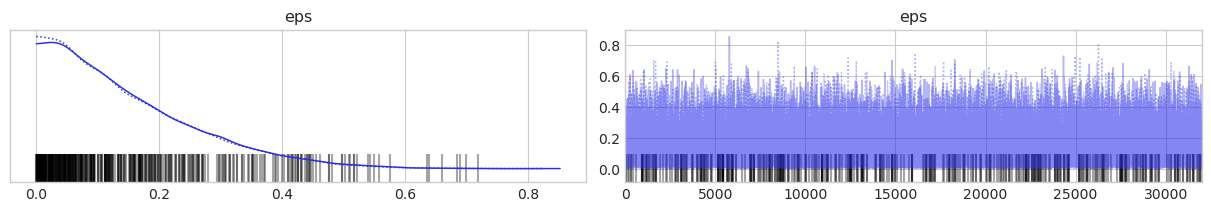

In [7]:
plot_trace(results['ratquad']['trace'], ['eps'])

<font size=5>
RatQuad

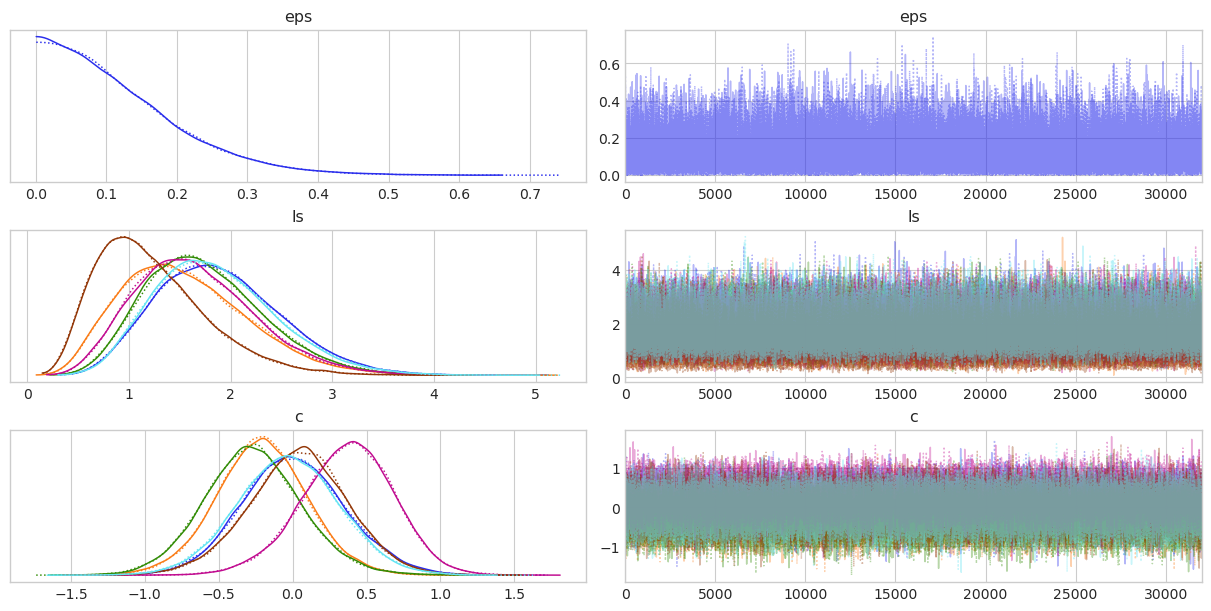

In [8]:
plot_trace(trace, ['eps', 'ls', 'c'])

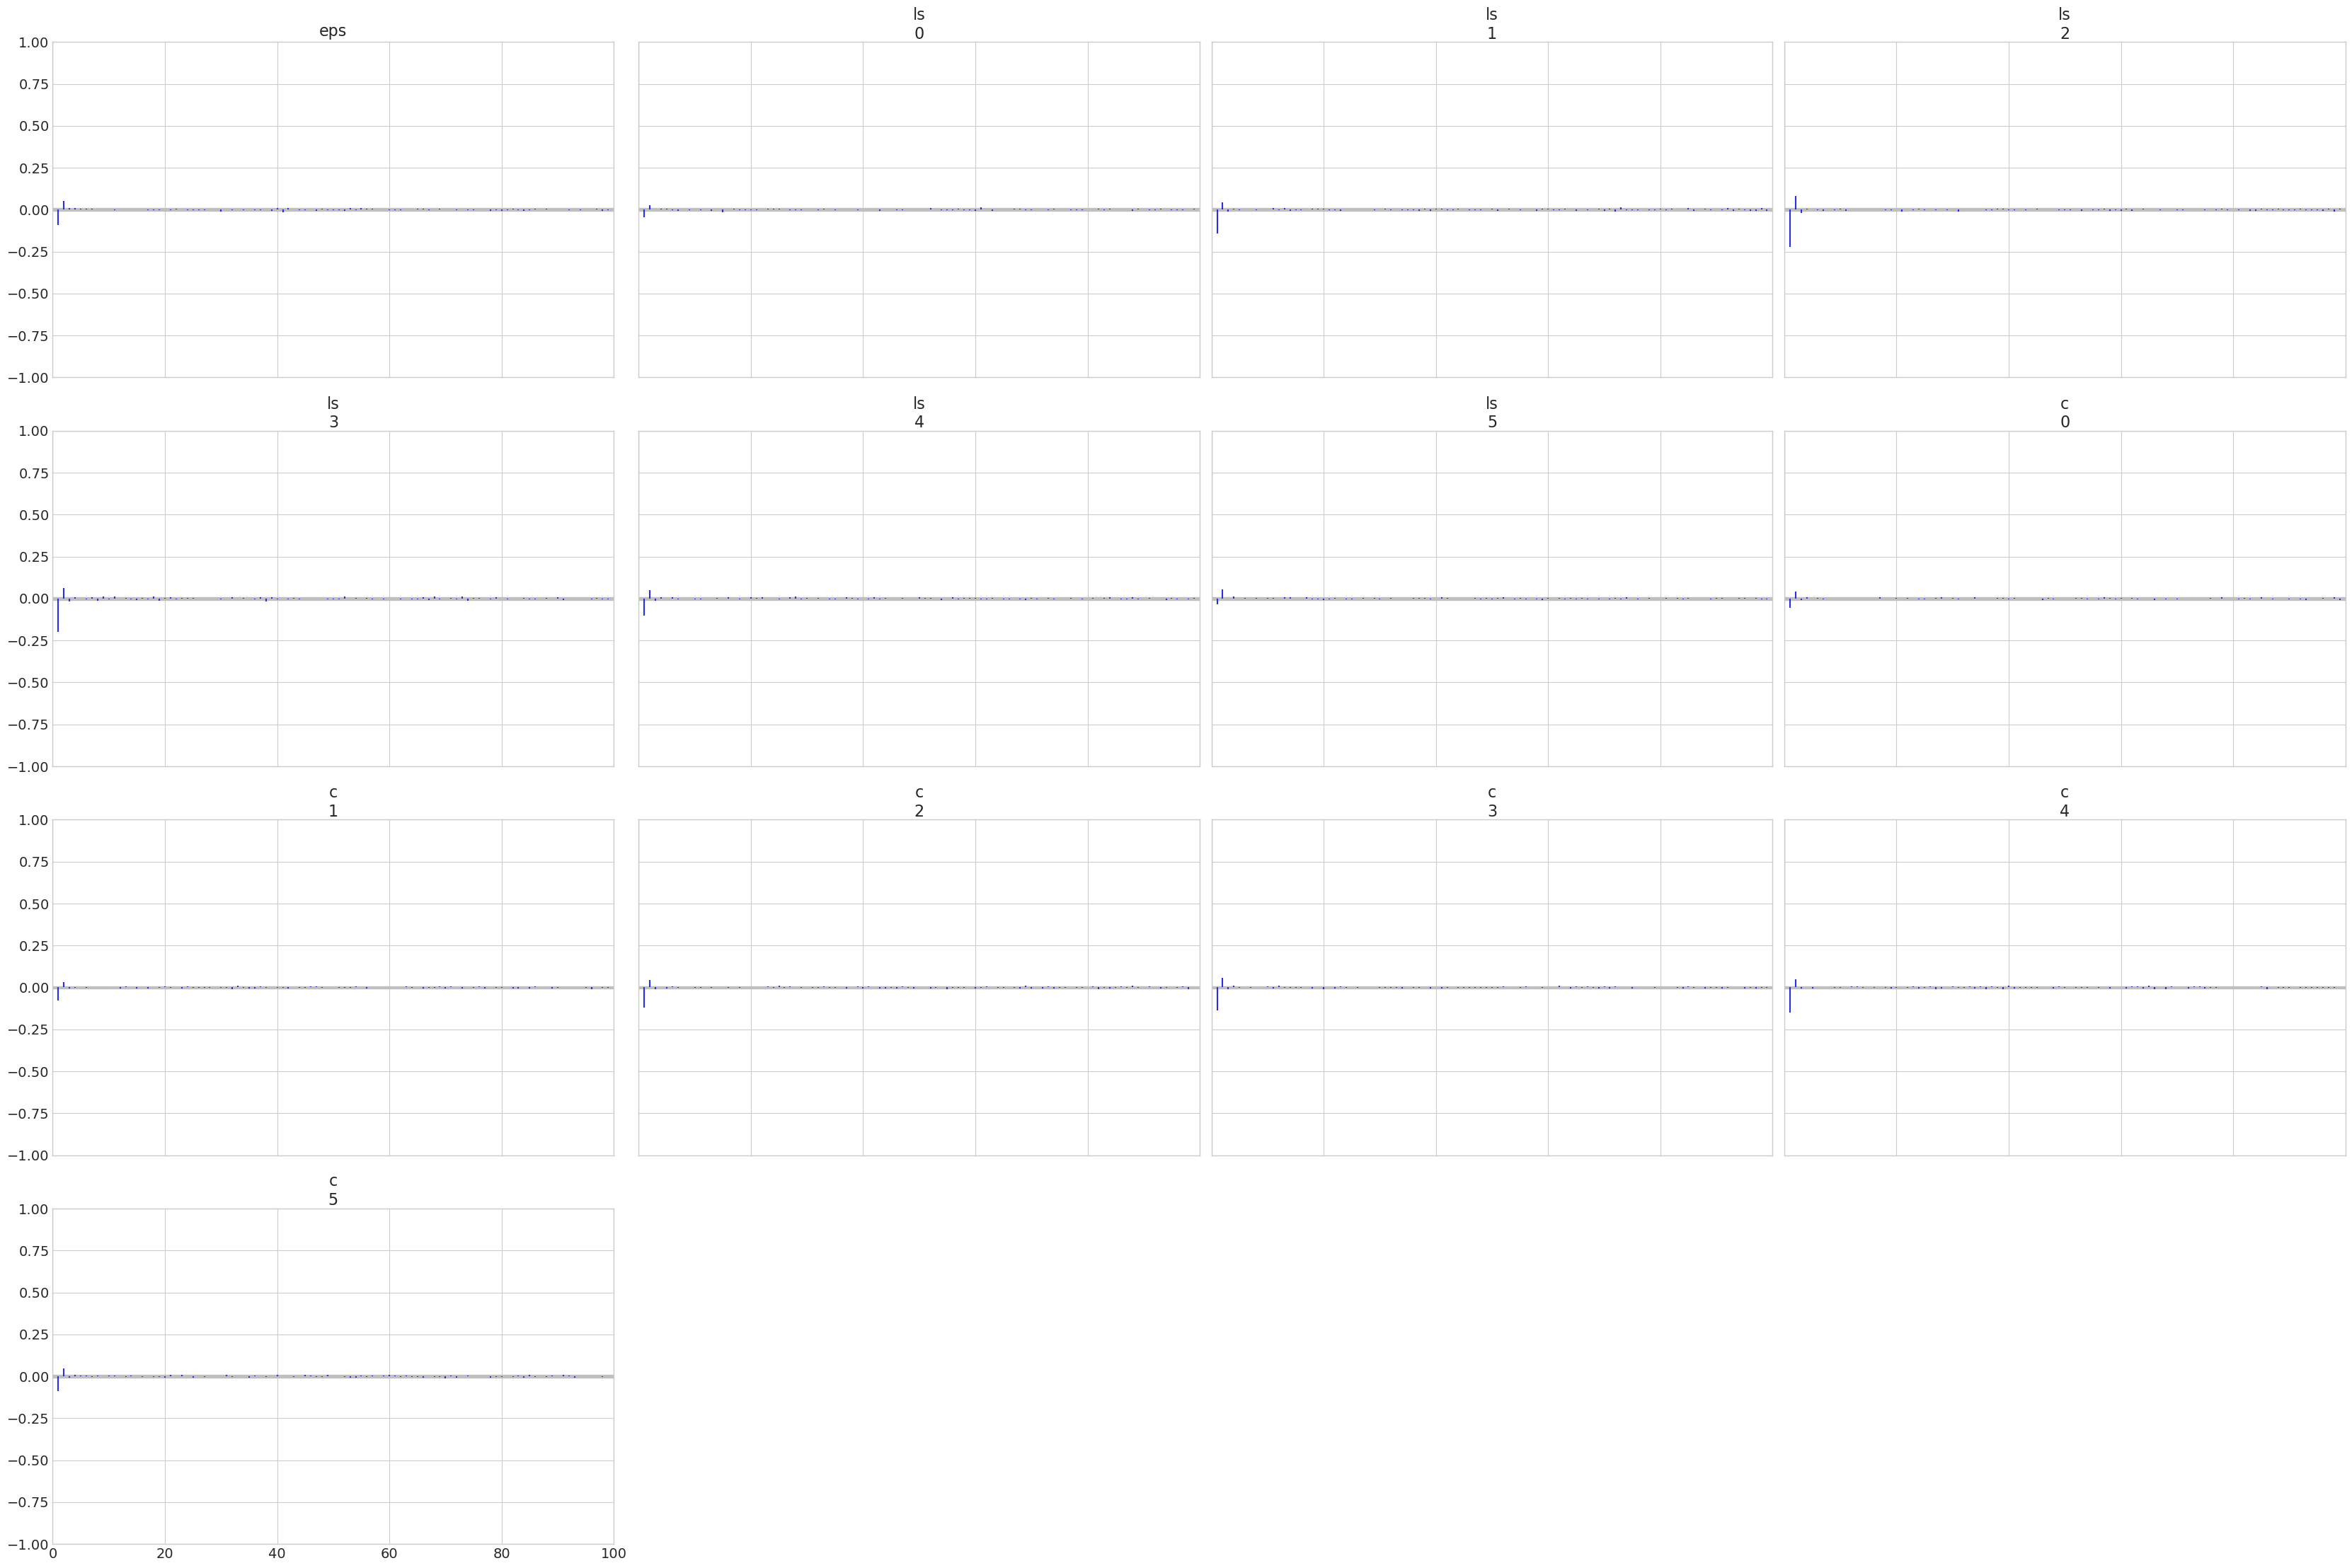

In [9]:
az.plot_autocorr(trace, var_names=['eps', 'ls', 'c'], combined=True)
plt.show()

In [10]:
pred_samples = gp_model.sample_conditional(trace, x_std_data, 'f_pred', num_pred_samples=2048)

C:\Users\pasqu\.conda\envs\pymc_env\lib\site-packages\pymc3\distributions\posterior_predictive.py:248: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


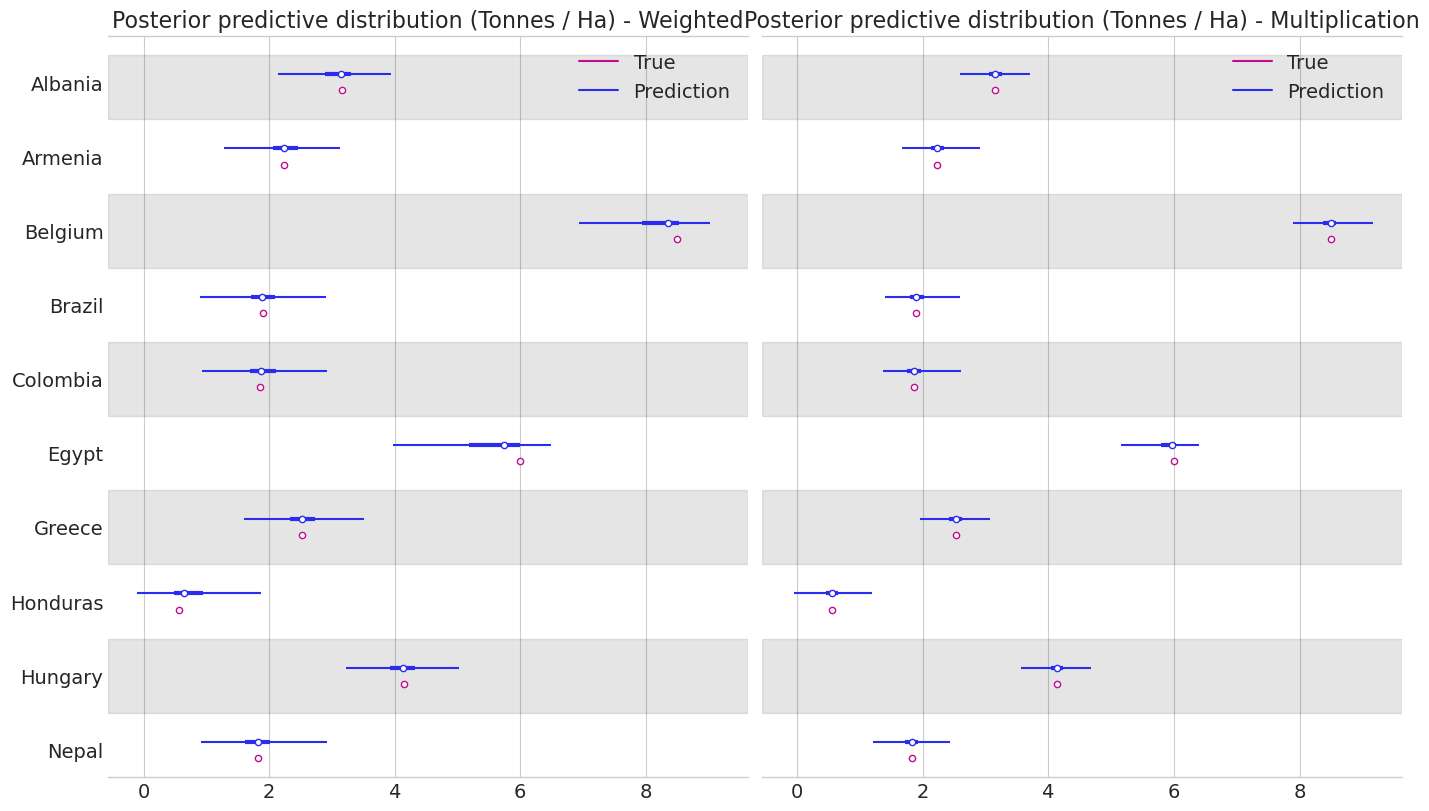

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
plot_test(results['exp_linear_weighted']['pred_samples'][:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax1, title='Posterior predictive distribution (Tonnes / Ha) - Weighted')
plot_test(pred_samples[:, test_indices], y_mean, y_stddev,
          y_test_data, countries[test_indices], axes=ax2, title='Posterior predictive distribution (Tonnes / Ha) - Multiplication')
plt.show()

In [15]:
mae = compute_mae(pred_samples, y_mean, y_stddev, y_data)
print("Weighted      MAE: {:.4f} (Tonnes / Ha)".format(results['exp_linear_weighted']['mae'] * 1e-4))
print("Multiplicated MAE: {:.4f} (Tonnes / Ha)".format(mae * 1e-4))

Weighted      MAE: 0.0520 (Tonnes / Ha)
Multiplicated MAE: 0.0049 (Tonnes / Ha)


<font size=5>
Again, with this combination of kernels we get the lowest error and tighter predictive distributions
    <br><br>

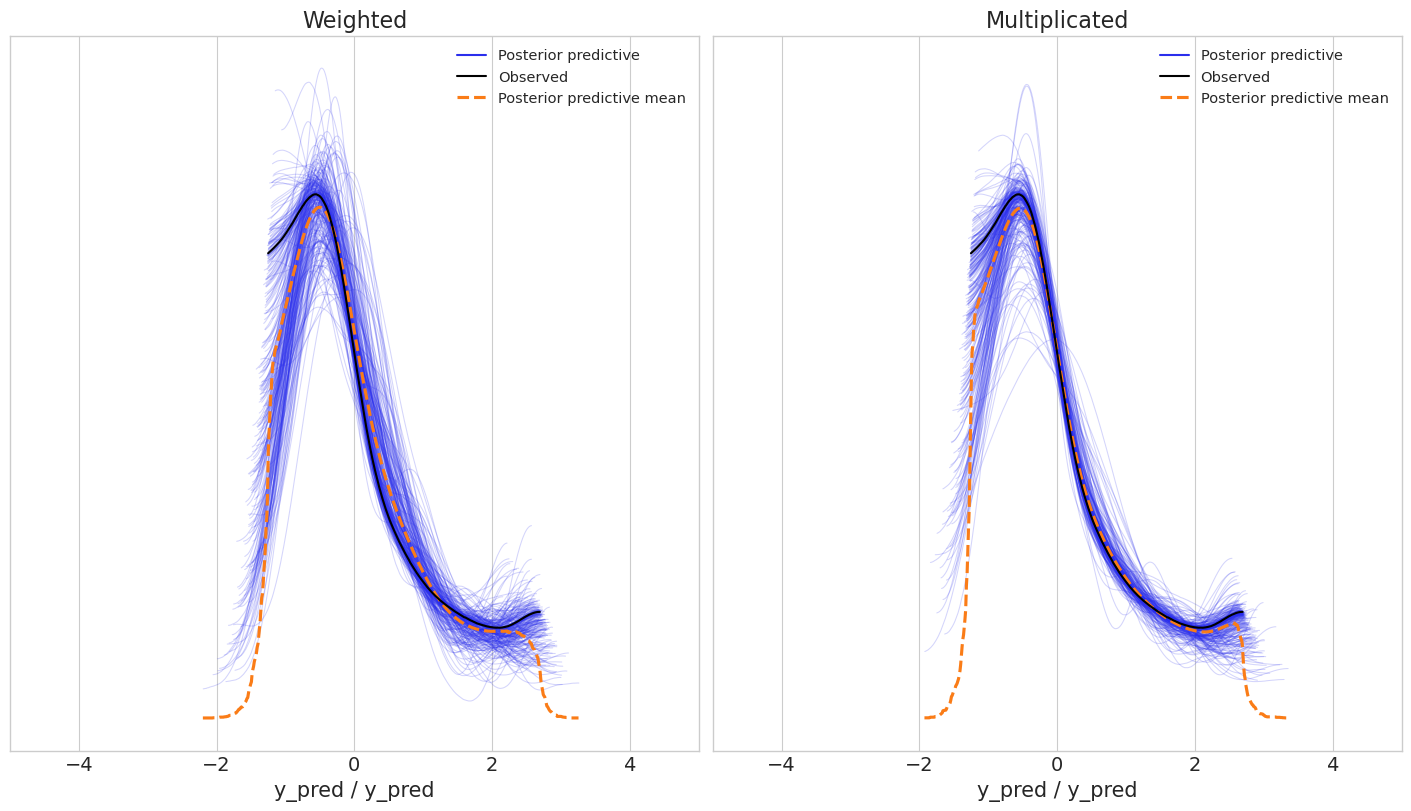

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8), sharex=True, sharey=True)
ax1.set_title('Weighted')
ax2.set_title('Multiplicated')

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':results['exp_linear_weighted']['pred_samples']}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax1)
ax1.set_xlim((-5, 5))
plt.plot()

ppc_data = az.from_pymc3(posterior_predictive={'y_pred':pred_samples}, model=model)
az.plot_ppc(ppc_data, num_pp_samples=256, ax=ax2)
ax1.set_xlim((-5, 5))
plt.plot()
plt.show()

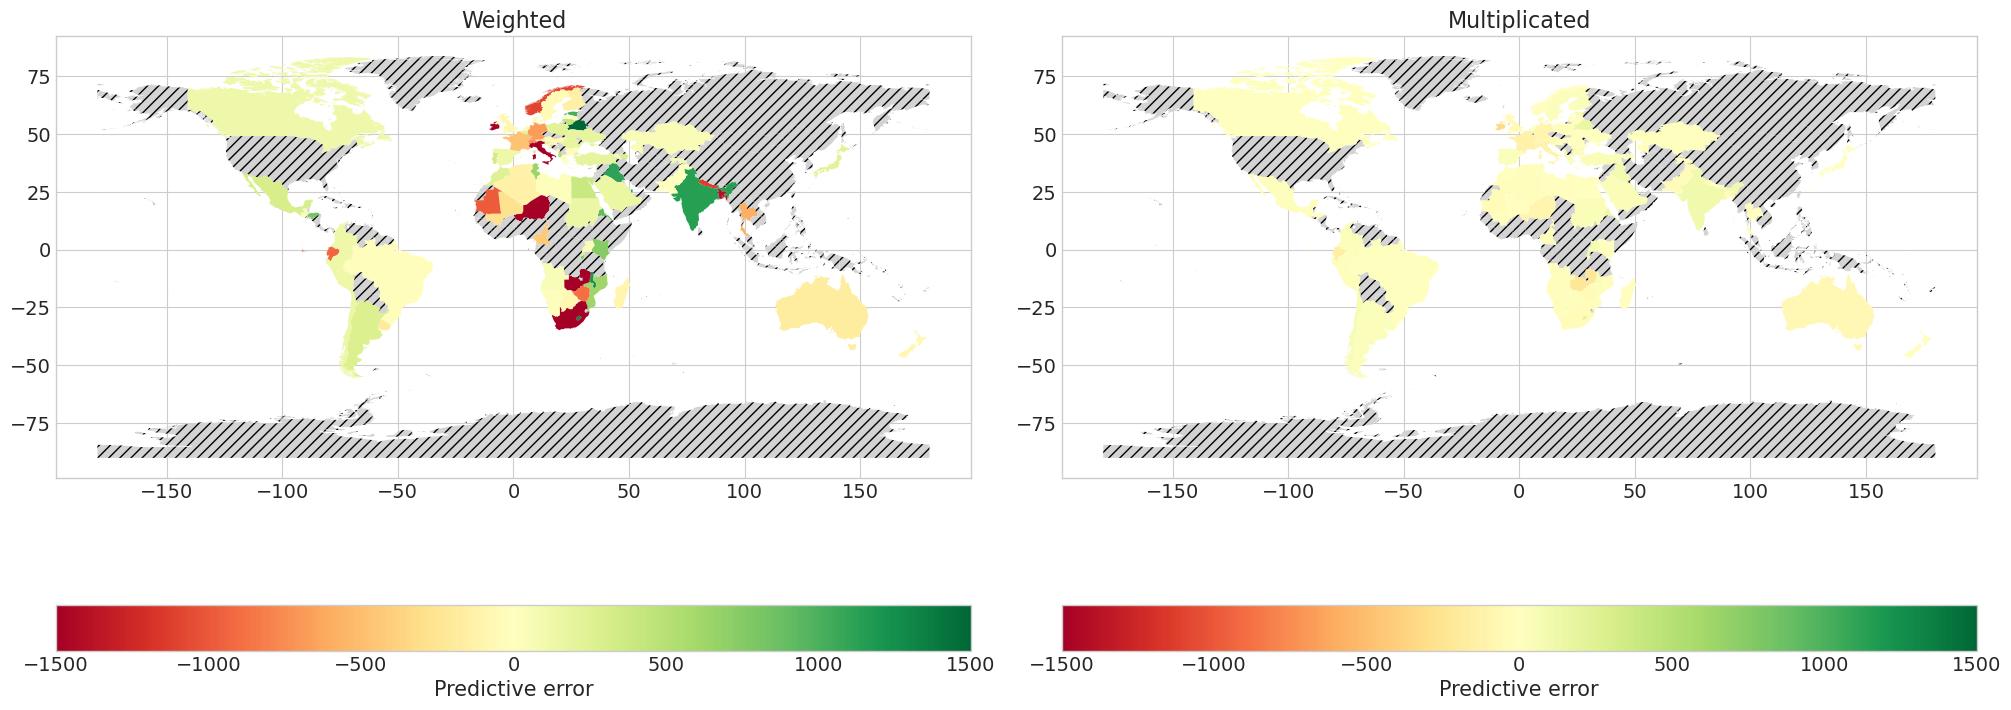

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20))
ax1.set_title('Weighted')
ax2.set_title('Multiplicated')
world_error_plot(world, results['exp_linear_weighted']['pred_samples'], y_mean, y_stddev, y_data, axes=ax1, max_error=1500)
world_error_plot(world, pred_samples, y_mean, y_stddev, y_data, axes=ax2, max_error=1500)
plt.show()

In [20]:
results['exp_linear_mul'] = {
    'trace': trace,
    'pred_samples': pred_samples,
    'mae': mae,
}

# Conclusions
<font size=5>
    
- GPs are <i>more expressive</i> than classic Bayesian models
- Can <i>fit better</i> data distributions
    - Classic Bayesian models had an $\epsilon$ distribution centered always above <b>0.7</b>
    - With GPs the mean approacches <b>0</b>
    - Potato Yield Prediction:
        - Lowest MAE with classic models: <b>4.76</b> (Tonnes / Ha)
        - Lowest MAE with GPS: <b>0.16</b> (Tonnes / Ha)
    
BUT
    
- Require a significant <i>greater amount of time</i> to fit
    - Matrix inversion calucalations required for each sample
- Require more parameter tuning 
    - <i>Less computationally stable</i> -> they diverge more easily

## Load and save results

In [6]:
results = {}

In [2]:
# Load results
with open('yp_wheat.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [16]:
# Save results
with open('yp_wheat.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
rs = results['exp_linear_weighted']
trace = rs['trace']
pred_samples = rs['pred_samples']
mae = rs['mae']
r2 = rs['r2']

In [3]:
results.keys()

dict_keys(['expquad', 'poly', 'exp', 'ratquad', 'exp_linear_weighted'])

In [46]:
rs = results['matern32']
trace = rs['trace']
pred_samples = rs['pred_samples']
mae = rs['mae']
r2 = rs['r2']